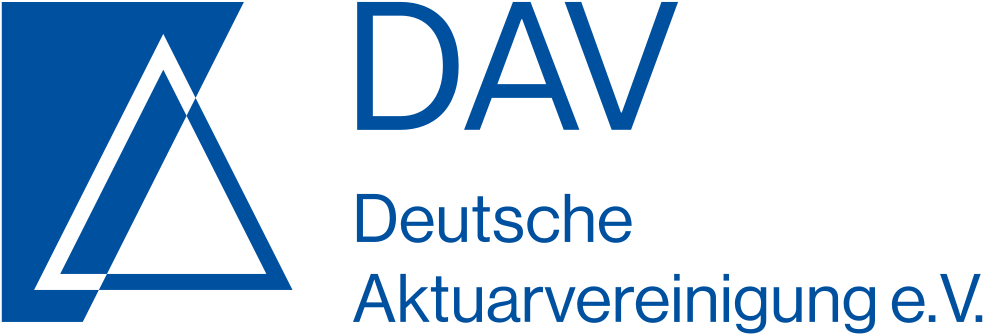
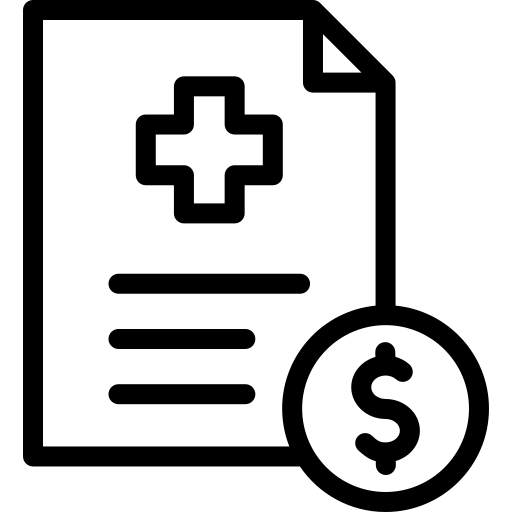

<p style="font-size:19px; text-align:left; margin-top:    25px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Model-Agnostic Explainability Methods for Regression Problems:<br>
A Case Study on Medical Costs Data</b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 25px">Dr. Simon Hatzesberger (<a href="mailto:simon.hatzesberger@gmail.com">simon.hatzesberger@gmail.com</a>)

<hr style="width:50%;">
<p style="font-size:16px; font-style:italic; margin-left:10%; margin-right:10%; margin-bottom: 1em;">
In this Jupyter Notebook, we offer a practical walkthrough for actuaries and data scientists on applying model-agnostic explainability methods to regression tasks, with a medical costs dataset serving as our case study.
</p>
<p style="font-size:16px; font-style:italic; margin-left:10%; margin-right:10%; margin-top: 1em; margin-bottom: 1em;">
It illuminates both global methods—such as surrogate models, PDPs, ALE plots, and permutation feature importances—for macro-level understanding of model behavior, and local methods—like SHAP, LIME, and ICE plots—for micro-level insights on individual predictions.
</p>
<p style="font-size:16px; font-style:italic; margin-left:10%; margin-right:10%; margin-top: 1em;">
The notebook provides practical code examples that readers can easily adopt, thereby providing a user-friendly introduction to using XAI methods to enhance transparency and reliability of their predictive models.
<hr style="width:50%;">

<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Table of Contents</h1>

[1. Introduction](#section_introduction)

[2. Brief Exploratory Data Analysis](#section_analysis)

[3. Developing and Evaluating an Opaque Machine Learning Model](#section_fitting)

[4. Global Model-Agnostic Explainability Methods](#section_global)<br>
&emsp;&emsp;&emsp;[4.1 Global Surrogate Model](#subsection_surrogate)<br>
&emsp;&emsp;&emsp;[4.2 Partial Dependence Plot (PDP)](#subsection_pdp)<br>
&emsp;&emsp;&emsp;[4.3 Accumulated Local Effects (ALE)](#subsection_ale)<br>
&emsp;&emsp;&emsp;[4.4 Permutation Feature Importance (PFI)](#subsection_pfi)

[5. Local Model-Agnostic Explainability Methods](#section_local)<br>
&emsp;&emsp;&emsp;[5.1 Shapley Additive Explanations (SHAP)](#subsection_shap)<br>
&emsp;&emsp;&emsp;[5.2 Local Interpretable Model-Agnostic Explanations (LIME)](#subsection_lime)<br>
&emsp;&emsp;&emsp;[5.3 Individual Conditional Expectation (ICE)](#subsection_ice)

[6. Limitations and Outlook](#section_limitations)

[A. Appendix](#section_appendix)<br>
&emsp;&emsp;&emsp;[A.1 Adapting this Notebook's Code to Other Machine Learning Models](#subsection_othermlmodels)<br>
&emsp;&emsp;&emsp;[A.2 Deep Dive: PDP vs. ALE](#subsection_actuarialdiligencePDPALE)<br>
&emsp;&emsp;&emsp;[A.3 Deep Dive: Diverse Feature Importance Methods](#subsection_actuarialdiligencePDPALE)<br>
&emsp;&emsp;&emsp;[A.4 Deep Dive: Variants of SHAP](#subsection_actuarialdiligenceSHAP)<br>

[References](#section_references)

<h1 id="section_introduction" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">1. Introduction</h1>

The primary objective of this notebook is to showcase a variety of techniques for interpreting the internal workings and predictive behavior of machine learning models in regression problems. Our goal is to deliver insights that span two critical levels of model understanding: the general workings of a machine learning model, which we refer to as global explainability, and the specific factors driving individual predictions, known as local explainability. Implementing these forms of explainable artificial intelligence (XAI) is crucial, as it empowers stakeholders—including model developers, regulatory bodies, and executive management—to make well-informed decisions rather than relying on 'black box' models. Readers are encouraged to apply—or at least find inspiration in—the approaches and code snippets that will be shared in this work.

Throughout this case study, we analyze a slightly modified version of the medical costs dataset found in [[1]](#section_references). Our regression problem is to predict individual medical costs billed by health insurance based on personal factors such as age, sex, body mass index (BMI), the number of children covered by the health insurance, smoking status, and regional location within the US. We aim to shed light on the model's decision-making process with model-agnostic explainability methods, rather than solely maximizing the predictive accuracy. Therefore, we apply these methods to a selected machine learning model for practical illustration.

The remainder of this notebook is as follows. [Section 2](#section_analysis) contains a brief exploratory data analysis (EDA) of the medical cost dataset, acquainting us with the data and its predictive features. [Section 3](#section_fitting) focuses on training and evaluation of a selected machine learning model, CatBoost, applied to our regression problem. [Section 4](#section_global) introduces global model-agnostic explainability techniques, specifically examining global surrogate models ([Subsection 4.1](#subsection_surrogate)), partial dependence plots ([Subsection 4.2](#subsection_pdp)), accumulated local effects ([Subsection 4.3](#subsection_ale)), and permutation feature importance ([Subsection 4.4](#subsection_pfi)). [Section 5](#section_local) contrasts this global perspective with local explanation methods such as SHAP ([Subsection 5.1](#subsection_shap)), LIME ([Subsection 5.2](#subsection_lime)), and individual conditional expectations ([Subsection 5.3](#subsection_ice)). [Section 6](#section_limitations) concludes the notebook by discussing the limitations of our case study and presenting perspectives on future work. Finally, the [Appendix](#section_appendix) delivers a technical guide on applying the XAI methods on machine learning models that do not inherently handle categorical features ([Subsection A.1](#subsection_a1)), along with detailed examinations of selected actuarial diligence notes mentioned throughout the notebook ([Subsection A.2](#subsection_a2), [Subsection A.3](#subsection_a3), and [Subsection A.4](#subsection_a4)).

<h1 id="section_analysis" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">2. Brief Exploratory Data Analysis</h1>

Before diving into a brief exploratory data analysis (EDA), we import all libraries that are used throughout this notebook, define global constants, and set a random seed to ensure consistency and reproducibility.

In [1]:
# Libraries for data processing
import numpy as np
import pandas as pd

# Libraries for model development, evaluation, and preprocessing
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

# Libraries for model explainability
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import shap
shap.initjs()
from PyALE import ale
from lime.lime_tabular import LimeTabularExplainer

# Libraries for visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Configurations for pandas display options and matplotlib inline backend
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Color palette for visualizations
COLOR_LIGHT, COLOR_DARK = '#4BB9E6', '#0050A0'

# Global constants and settings
TRAIN_RATIO = 0.70   # Ratio for splitting data into training and test sets
RANDOM_SEED = 12345  # Seed for reproducibility of random operations

# Configuration for warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

c:\Users\simon\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For initial insights into the medical costs dataset, we conduct a basic EDA. We begin by loading the dataset, inspecting the first ten entries, and reviewing the overall structure, including the number of rows, columns, and any missing values, to provide a concise overview of the data.

In [2]:
# Load the medical costs dataset
df_raw = pd.read_csv('MedicalCosts.csv')

# Output the dimensions of the dataset and the total number of missing values
num_entries = df_raw.shape[0]
num_features = df_raw.shape[1]
total_missing = df_raw.isnull().sum().sum()

print(f"The dataset contains {num_entries} entries and {num_features} features.")
print(f"There are {total_missing} missing values in the dataset.")

# Display the first ten entries to preview the data
df_raw.head(10)

The dataset contains 1338 entries and 7 features.
There are 0 missing values in the dataset.


,AGE,SEX,BMI,NUMBERCHILDREN,SMOKER,REGION,MEDICALCHARGES
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


The dataset consists of several personal features, and our objective is to predict the medical charges of an individual based on these attributes. Next, we provide brief descriptions of these features for a clear understanding of the dataset's contents:
* `AGE`: The age of the policyholder.
* `SEX`: The policyholder's gender, with categories 'male' or 'female'.
* `BMI`: Body Mass Index, which uses weight and height to categorize the individual's body weight status.
* `NUMBERCHILDREN`: The count of children or dependents included under the policyholder's coverage.
* `SMOKER`: A binary indicator of whether the policyholder smokes, denoted by 'yes' or 'no'.
* `REGION`: The policyholder's residential region within the US, classified into 'northeast', 'southeast', 'southwest', or 'northwest' areas.
* `MEDICALCHARGES`: The total amount billed for the policyholder's medical services, to be reimbursed by the insurer.

In the following, histograms and boxplots are used to illustrate the distribution of each numerical feature.

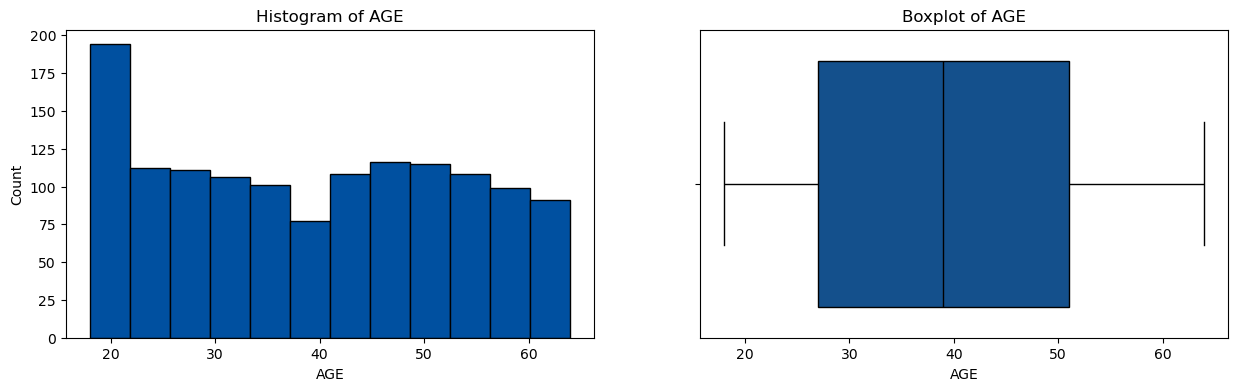

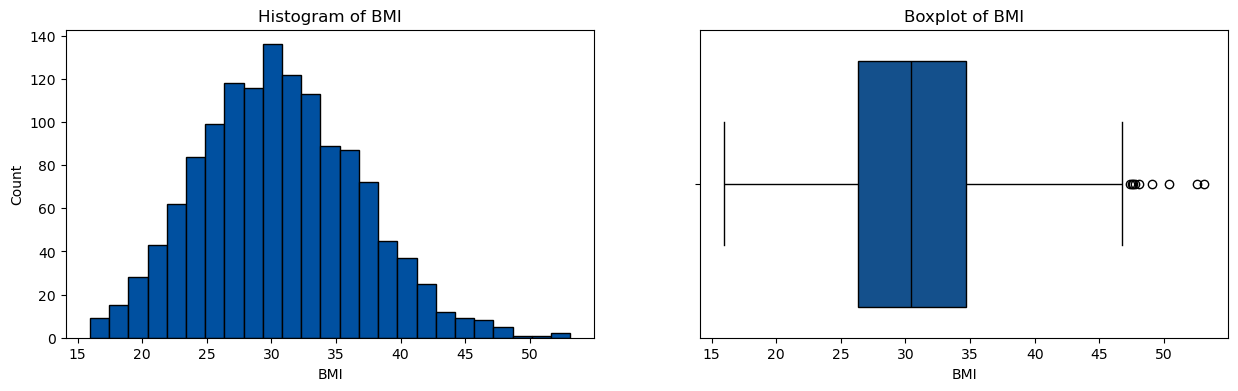

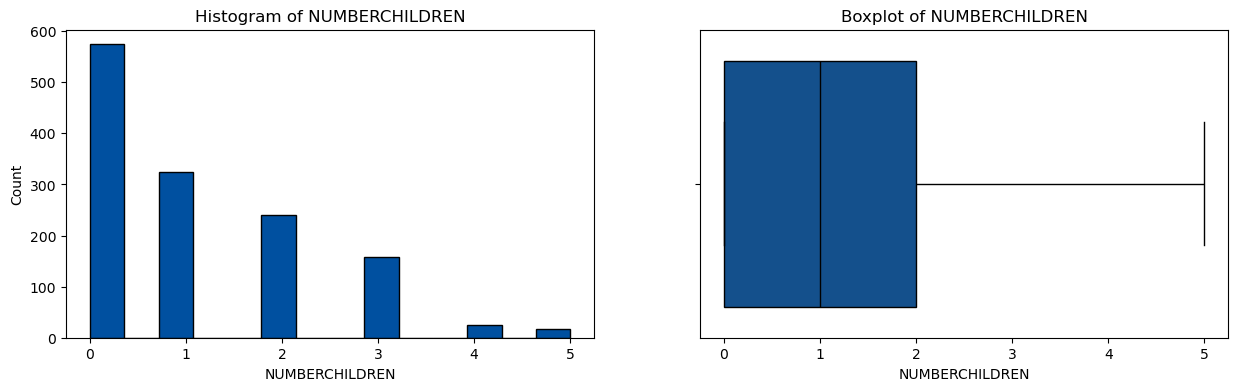

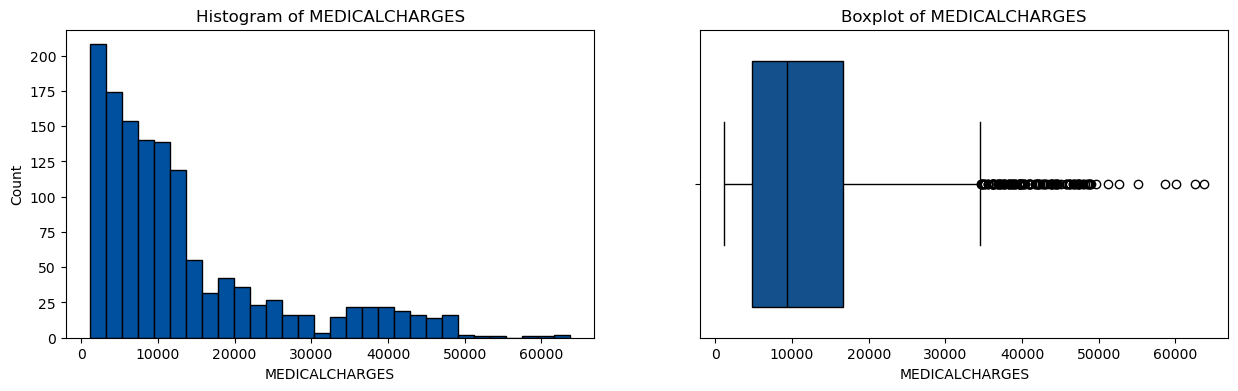

In [3]:
# List of numerical columns in the dataset
numerical_features = ['AGE', 'BMI', 'NUMBERCHILDREN', 'MEDICALCHARGES']

# Plot histograms and boxplots for each numerical feature
for col in numerical_features:
    # Create a new figure with a specific size
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    # Histogram: distribution of the feature
    sns.histplot(df_raw[col], ax=ax[0], color=COLOR_DARK,
                 edgecolor='black', alpha=1)
    ax[0].set_title(f'Histogram of {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Count')

    # Boxplot: spread of the feature
    sns.boxplot(x=df_raw[col], ax=ax[1], color=COLOR_DARK,
                linecolor='black')
    ax[1].set_title(f'Boxplot of {col}')
    ax[1].set_xlabel(col)

    # Display all plots
    plt.show()

Having visualized the individual distributions and variations of the numerical features through histograms and boxplots, we will next explore the relationships between these variables. To achieve this, we build a correlation matrix to illustrate the degree to which the features are linearly related to one another. This aims to uncover any strong correlations between features that could affect the behavior of our machine learning model.

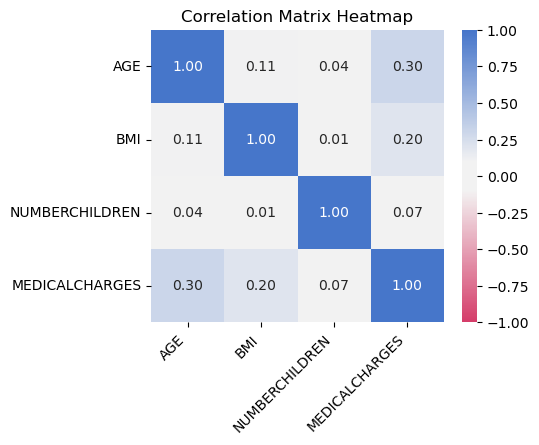

In [4]:
# Compute the correlation matrix for the numerical features
corr_matrix = df_raw[numerical_features].corr()

# Set the size of the heatmap
plt.figure(figsize=(5.5, 4.5))

# Generate a heatmap with annotation
sns.heatmap(corr_matrix, annot=True, square=True, fmt=".2f", vmin=-1, 
            vmax=1, center=0, cmap=sns.diverging_palette(0, 255, sep=27, 
            n=256))

# Diagonal text for the x-axis and title for the heatmap
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix Heatmap')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

The correlation matrix shows that both `AGE` and `BMI` have a moderate positive correlation with the target variable `MEDICALCHARGES`, suggesting that as age and BMI increase, medical expenses tend to rise accordingly. In contrast, `NUMBERCHILDREN` appears to have a minimal influence on `MEDICALCHARGES` and shows almost no correlation with other features. Furthermore, the three non-target features `AGE`, `BMI`, and `NUMBERCHILDREN` also exhibit almost no correlation with one another. These correlations provide preliminary insights for the upcoming regression analysis.

After examining the numerical features, we shift our focus to the categorical variables, visualizing their distributions with bar charts.

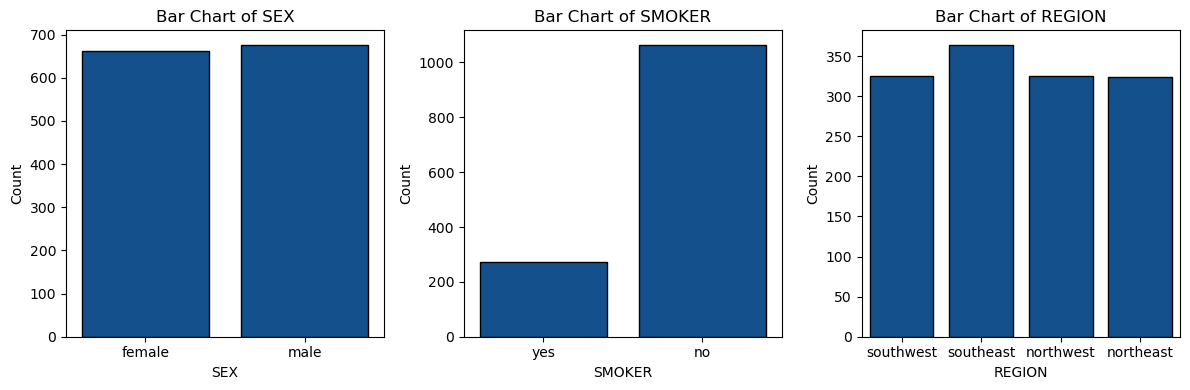

In [5]:
# List of categorical columns in the dataset
categorical_features = ['SEX', 'SMOKER', 'REGION']

# Create a single figure and a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(12, 4))

# Create bar charts for each categorical column
for i, col in enumerate(categorical_features):
    # Count plot on the appropriate subplot
    sns.countplot(x=col, data=df_raw, ax=axes[i], color=COLOR_DARK, 
                  edgecolor='black')
    
    # Set title and labels
    axes[i].set_title(f'Bar Chart of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Expanding our exploration of categorical variables, we employ boxplots to examine their impact on `MEDICALCHARGES`, providing a clearer visual representation of how these factors may drive healthcare costs.

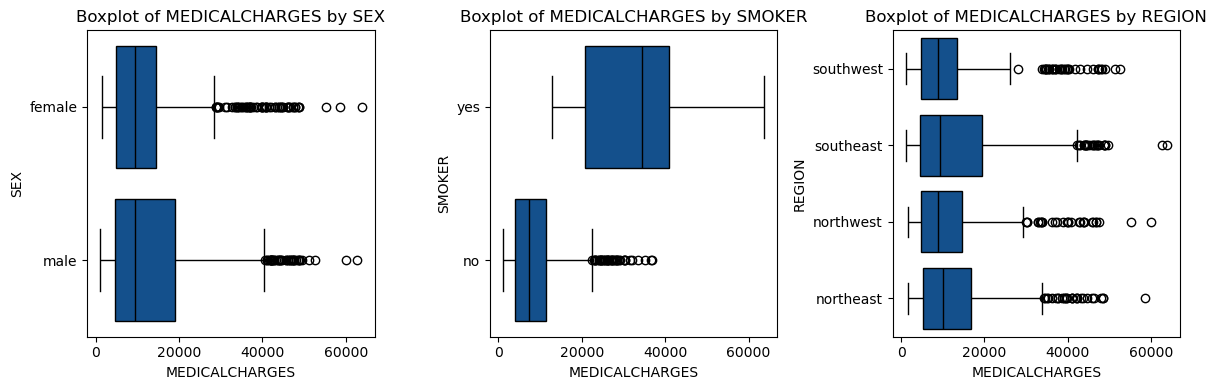

In [6]:
# Create a single figure and a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(12, 4))

# Create boxplots for each categorical column
for i, col in enumerate(categorical_features):
    # Boxplot on the appropriate subplot
    sns.boxplot(x='MEDICALCHARGES', y=col, data=df_raw, ax=axes[i], 
                color=COLOR_DARK, linecolor='black')
    
    # Set title and labels
    axes[i].set_title(f'Boxplot of MEDICALCHARGES by {col}')
    axes[i].set_xlabel('MEDICALCHARGES')
    axes[i].set_ylabel(col)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

The boxplots clearly demonstrate that being a `SMOKER` is associated with substantially higher `MEDICALCHARGES` compared to non-smokers, suggesting that smoking status is a pivotal determinant in predicting medical costs. Conversely, the features `SEX` and `REGION` do not show a significant effect on `MEDICALCHARGES`, indicating that these characteristics may not be critical in forecasting healthcare expenditures in this dataset.

<h1 id="section_fitting" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">3. Developing and Evaluating an Opaque Machine Learning Model</h1>

Building on our analysis from [Section 2](#section_analysis), we now turn to constructing a predictive machine learning model. We choose to implement a CatBoost model, acclaimed for handling categorical data natively, requiring minimal data preprocessing, and delivering strong predictive performance. However, since CatBoost is considered a black box model, it necessitates the use of XAI methods to decode its decisions, offering clarity into the mechanics that drive its predictions.

Before applying the CatBoost algorithm, we divide our dataset into two components: the set of predictor variables `X_raw` and the target variable `y`, consistent with conventional practices in supervised learning.

In [7]:
# Define the target variable
target = 'MEDICALCHARGES'

# Update the numerical_features list to exclude the target variable
numerical_features.remove(target)

# Set data type for categorical features to category for efficient processing
for cat_feature in categorical_features:
    df_raw[cat_feature] = df_raw[cat_feature].astype('category')

# Separate the dataset into explanatory features and the target variable
X_raw = df_raw.drop(target, axis=1)
y = df_raw[target]
features_X_raw = X_raw.columns

# Display data types of features for verification
print("Data types of features in X_raw:")
print(X_raw.dtypes)

# Split the data into training and testing sets based on predefined TRAIN_RATIO
# and use a consistent RANDOM_SEED for reproducibility
X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    X_raw, y, train_size=TRAIN_RATIO, random_state=RANDOM_SEED
)

# Output the shape of the training and testing sets to confirm the split
print(f"\nTraining set dimensions: {X_raw_train.shape}")
print(f"Test set dimensions:     {X_raw_test.shape}")

Data types of features in X_raw:
AGE                  int64
SEX               category
BMI                float64
NUMBERCHILDREN       int64
SMOKER            category
REGION            category
dtype: object

Training set dimensions: (936, 6)
Test set dimensions:     (402, 6)


With data preparations complete, we proceed to train the CatBoost model using our training dataset and measure its performance on the test data with the root mean squared error (RMSE) as our primary evaluation metric and the $R^2$ score for additional validation.

In [8]:
# Define the CatBoost regressor with specified parameters and a random seed
# for reproducibility
model_CB_raw = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    random_seed=RANDOM_SEED,
    allow_writing_files=False
)

# Fit the CatBoost model
model_CB_raw.fit(X_raw_train, y_train, cat_features=categorical_features,
                 verbose=False)

# Predict on the test set
predictions_CB_raw = model_CB_raw.predict(X_raw_test)

# Evaluate the model on the test set using RMSE and R² score
rmse_CB_raw = mean_squared_error(y_test, predictions_CB_raw, squared=False)
r2_CB_raw = r2_score(y_test, predictions_CB_raw)

# Print the RMSE and R² score
print(f"RMSE for the CatBoost model on the test data: {rmse_CB_raw:.2f}")
print(f"R² score for the CatBoost model on the test data: {r2_CB_raw:.2f}")

RMSE for the CatBoost model on the test data: 4360.91
R² score for the CatBoost model on the test data: 0.87


The CatBoost model demonstrates strong predictive capabilities, evidenced by its low RMSE and high $R^2$ values, confirming its effectiveness in making forecasts. This machine learning model will serve as the foundation for the XAI techniques discussed in the upcoming sections.

As we progress through this notebook, encoded representations of our dataset's categorical features will be required at multiple points (see, e.g., [Subsection 4.1](#subsection_surrogate) or [Subsection 5.2](#subsection_lime)). To this end, we will now apply one-hot encoding to our categorical features and then partition the data into training and test sets once more.

In [9]:
# Apply one-hot encoding to the categorical features and display the first five entries
df_enc = pd.get_dummies(df_raw)
display(df_enc.head(5))

# Separate the encoded dataset into explanatory features and the target variable
X_enc = df_enc.drop(target, axis=1)
features_X_enc = X_enc.columns

# Display data types of features for verification
print("Data types of features in X_enc:")
print(X_enc.dtypes)

# Split the data into training and testing sets based on predefined TRAIN_RATIO
# and use a consistent RANDOM_SEED for reproducibility
X_enc_train, X_enc_test, _, _ = train_test_split(
    X_enc, y, train_size=TRAIN_RATIO, random_state=RANDOM_SEED
)

# Output the shape of the training and testing sets to confirm the split
print(f"\nTraining set dimensions: {X_enc_train.shape}")
print(f"Test set dimensions:     {X_enc_test.shape}")

,AGE,BMI,NUMBERCHILDREN,MEDICALCHARGES,SEX_female,SEX_male,SMOKER_no,SMOKER_yes,REGION_northeast,REGION_northwest,REGION_southeast,REGION_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


Data types of features in X_enc:
AGE                   int64
BMI                 float64
NUMBERCHILDREN        int64
SEX_female            uint8
SEX_male              uint8
SMOKER_no             uint8
SMOKER_yes            uint8
REGION_northeast      uint8
REGION_northwest      uint8
REGION_southeast      uint8
REGION_southwest      uint8
dtype: object

Training set dimensions: (936, 11)
Test set dimensions:     (402, 11)


Equipped with our high-performing machine learning model, the next section will focus on global model-agnostic explainability methods to elucidate the model's general functionality. In the subsequent section, we will then address local model-agnostic techniques to analyze the decision-making process for individual predictions.

<h1 id="section_global" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">4. Global Model-Agnostic Explainability Methods</h1>

In this section, we explore <i>global</i> model-agnostic explainability methods, which provide insights into the overall behavior of the machine learning model developed in the previous section. These techniques are designed to offer a holistic understanding of the model's decisions across the entire data space, allowing to identify general trends and patterns that the model uses to make predictions. In our study, we concentrate on some of the most prominent global model-agnostic methods, namely global surrogate models, partial dependence plots, accumulated local effects, and permutation feature importances. Additional techniques are cited for interested readers in [Section 6](#section_limitations).

<h1 id="subsection_surrogate"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    4.1 Global Surrogate Model
    <a class="anchor-link"
       href="#c1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<i>Main Idea:</i>

The core concept of global surrogate models is straightforward: rather than attempting to interpret a complex, opaque model—often referred to as a black box model, such as a gradient boosting model—directly, one substitutes it with a more interpretable white box model (e.g., a decision tree) and extracts insights from this substitute. 

<i>Operational Details:</i>

To implement this approach, one should undertake the following steps:

1. Train the original (black box) model on the data `X` and labels `y` (or subsets thereof).

2. Generate the model's predictions `y_hat_original` using the input `X`.

3. Select an interpretable surrogate model and train it on `X` and `y_hat_original`.

4. Evaluate how accurately the surrogate model approximates the original model, and if the approximation is satisfactory, interpret the surrogate to gain insights into the workings of the original model.

Steps 1 and 2 are typically straightforward processes. In Step 3, one has to ensure that the surrogate model is indeed easy to interpret (i.e., a white box model). Step 4 is critical: the evaluation measure selected must accurately reflect the fidelity of the surrogate model to the original. The $R^2$ score is commonly used for this purpose, calculated as
$$
R^2 := 1 - \frac{\sum_{{i=1}}^n \left( \hat{y}_i^{{\text{original}}} - \hat{y}_i^{{\text{surrogate}}} \right)^2}{\sum_{{i=1}}^n \left( \hat{y}_i^{{\text{original}}} - \bar{y}^{{\text{original}}} \right)^2}
$$
where
- $\hat{y}_i^{\text{original}}$ is the prediction from the original (black box) model for the $i$-th instance,
- $\hat{y}_i^{\text{surrogate}}$ is the prediction from the surrogate (interpretable) model for the $i$-th instance, and
- $\bar{y}^{\text{original}}$ is the mean over all the predictions from the original (black box) model.

Note that an $R^2$ score of 1 indicates perfect agreement, meaning the surrogate model's predictions are identical to those of the original. Conversely, an $R^2$ score near 0 indicates that the surrogate model provides little to no reliable insight into the original model's behavior.

<i>Application to the Medical Costs Dataset:</i>

Illustrating global surrogate models, we will replace the CatBoost model from [Section 3](#section_fitting) with both a decision tree and a linear regression model, which are known for their inherent explainability and status as 'white box' models.

We will begin by employing a flat decision tree as the surrogate model.

In [10]:
# Step 1: Training the CatBoost model has already been completed in Section 3
# via the following code
# model_CB_raw.fit(X_raw_train, y_train, cat_features=categorical_features,
#                  verbose=False)

# Step 2: Generate the predictions from the original (black box) model
pred_model_CB_raw = model_CB_raw.predict(X_raw_train)

# Step 3: Train a decision tree (white box) model as the surrogate
# We must use the encoded feature set `X_enc_train` since DecisionTreeRegressor
# cannot handle raw categorical data
surrogate_model_DT = DecisionTreeRegressor(max_depth=2, 
                                           random_state=RANDOM_SEED)
surrogate_model_DT.fit(X_enc_train, pred_model_CB_raw)

# Step 4: Evaluate the surrogate model's performance by comparing its 
# predictions to those of the black box model
pred_surrogate_model_DT = surrogate_model_DT.predict(X_enc_train)
r2_value_DT = r2_score(pred_model_CB_raw, pred_surrogate_model_DT)
print(f'R² score (decision tree surrogate): {r2_value_DT:.2f}')

R² score (decision tree surrogate): 0.95


The $R^2$ score is close to 1, which suggests that the decision tree provides a reliable approximation of the original CatBoost model. Consequently, we can reasonably expect that insights gained from analyzing the decision tree will reflect the workings of the more complex model. The most straightforward method to interpret a decision tree involves visual inspection of its internal branching structure.

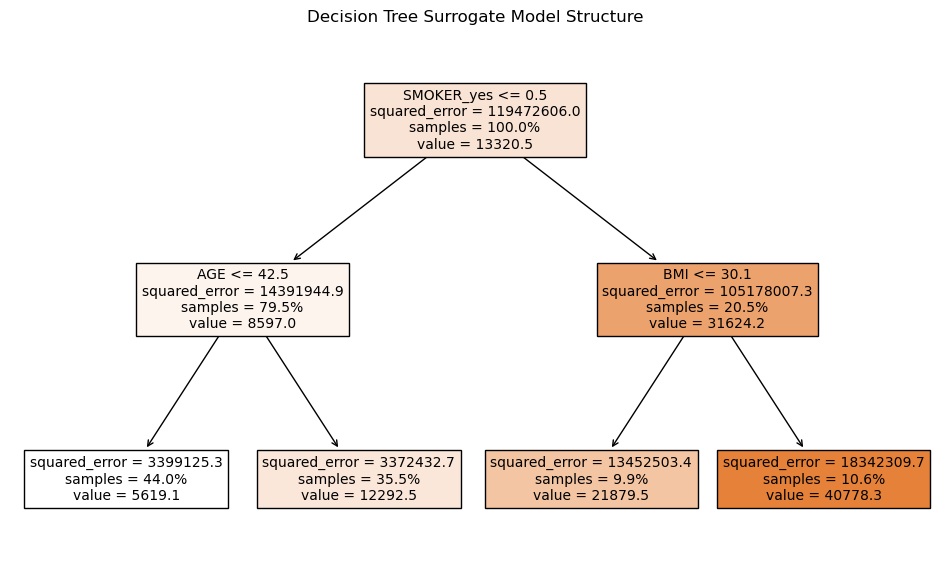

In [11]:
# Plot the fitted decision tree to gain insights into its prediction rules
plt.figure(figsize=(12, 7))

# Ensure `features_X_enc` is a list of feature names in the order they were
# encoded for use in the decision tree
plot_tree(surrogate_model_DT, feature_names=features_X_enc, fontsize=10,
          filled=True, proportion=True, precision=1)
plt.title('Decision Tree Surrogate Model Structure')
plt.show()

The decision tree visualization clearly identifies `SMOKER` as the most influential feature, with subsequent splits based on `AGE` and `BMI`. Note that the features `SEX`, `NUMBERCHILDREN`, and `REGION` do not appear in the given tree's structure, echoing the insights from the exploratory data analysis which suggested that these variables possess limited predictive influence. The decision tree can also be further analyzed, e.g., by examining its internal feature importances.

For our second example, we utilize a linear regression model to serve as an alternate global surrogate model. We will adhere to the same methodology previously demonstrated with the decision tree example.

In [12]:
# Step 1: Training the CatBoost model has already been completed in Section 3 
# via the following code
# model_CB_raw.fit(X_raw_train, y_train, cat_features=categorical_features, 
#                  verbose=False)

# Step 2: Generate the predictions from the original (black box) model has 
# already been completed before
# pred_model_CB_raw = model_CB_raw.predict(X_raw_train)

# Step 3: Train a linear regression (white box) model as the surrogate
# We must use the encoded feature set `X_enc_train` since linear regression 
# cannot handle raw categorical data
X_enc_train_with_const = sm.add_constant(
    X_enc_train.drop(columns=['SEX_male', 'SMOKER_no', 'REGION_southwest'])
)
surrogate_model_LR = sm.OLS(pred_model_CB_raw, X_enc_train_with_const)
results_LR = surrogate_model_LR.fit()

# Step 4: Evaluate the surrogate model's performance by comparing its 
# predictions to those of the black box model
pred_surrogate_model_LR = results_LR.predict(X_enc_train_with_const)
r2_value_LR = r2_score(pred_model_CB_raw, pred_surrogate_model_LR)
print(f'R² score (linear regression surrogate): {r2_value_LR:.2f}')

R² score (linear regression surrogate): 0.87


The $R^2$ score for the linear regression model, while somewhat lower than that of the decision tree, is still considered acceptable. However, whether this value is definitively satisfactory can be subjective. For the purposes of this example, we consider the score adequate and proceed to examine the internals of the linear regression model by analyzing its coefficients.

In [13]:
# Print the summary of the fitted linear regression model
# This includes statistics such as coefficients, R-squared, etc.
print(results_LR.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     778.2
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:42:42   Log-Likelihood:                -9076.0
No. Observations:                 936   AIC:                         1.817e+04
Df Residuals:                     927   BIC:                         1.821e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.117e+04    808.867  

Upon examining the linear regression coefficients, we see that `SMOKER` status is the most influential factor, with a large positive coefficient highlighting its importance. Both `AGE` and `BMI` also show positive and significant contributions to the model's predictions. In contrast, `NUMBERCHILDREN` has a noticeable but only minor impact. The coefficients for `SEX` and different `REGION` categories suggest these variables do not significantly affect the predictions, given their smaller magnitudes and high $p$-values.

<i>Advantages and Disadvantages:</i>

At the end of this section, we list several advantages and disadvantages of global surrogate models:

<div style="background-color: #d5ffd9; border-left: 4px solid #569253; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Advantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Simplicity and Interpretability</u>:<br>
        Global surrogate models, such as linear regression or decision trees, are inherently simpler and more interpretable than complex machine learning models. They approximate the behavior of the complex model, making it easier to understand the overall trends and patterns that the model captures.</li>
        <li style="margin-bottom: 14px"><u>Insight into Feature Importance</u>:<br>
        Global surrogate models can offer quantitative measures of feature importance, helping to identify which variables have the most significant impact on the model's predictions.</li>
        <li style="margin-bottom: 14px"><u>Regulatory Compliance</u>:<br>
        Global surrogate models can be particularly beneficial in the insurance industry, where actuaries are often required to provide clear explanations for their predictive models under various regulations. These models can bridge the gap between complex algorithmic decisions and the need for transparent, interpretable explanations that satisfy regulatory mandates.</li>
    </ul>
</div>

<div style="background-color: #ffd8d8; border-left: 4px solid #925653; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Disadvantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Approximation Error</u>:<br>
        Global surrogate models are simplifications that aim to mimic the complex model's decisions. The fidelity of a surrogate model may not always be high, leading to approximation errors where the surrogate's explanations might not fully capture the behavior of the original model.</li>
        <li style="margin-bottom: 14px"><u>Subjectivity in Thresholds for Similarity</u>:<br>
        There is inherent subjectivity in determining the fidelity level at which a surrogate model is considered adequately accurate. Metrics like R² lack universal benchmarks for sufficiency, with acceptability varying by application and the need for precision in explanations.</li>
        <li style="margin-bottom: 14px"><u>Loss of Granularity</u>:<br>
        While global surrogate models are good for providing an overall understanding, they might not capture local behaviors or interactions specific to individual predictions. This loss of granularity can be critical for use cases where individual decisions are as important as the overall trend.</li>
        <li style="margin-bottom: 14px"><u>Risk of Misinterpretation</u>:<br>
        Users might incorrectly assume that the explanations provided by the surrogate model fully represent the inner workings of the complex model, which can lead to overconfidence in the simplicity of the explanations and misunderstandings when the model behaves unexpectedly.</li>
        <li style="margin-bottom: 14px"><u>Complexity Trade-off</u>:<br>
        The more interpretable a surrogate model is, typically, the less accurate it becomes. This creates a trade-off between how well the surrogate model represents the complex model and how easily its decisions can be interpreted. Choosing the right balance is a subjective process and can impact the effectiveness of the explanations.</li>
    </ul>
</div>

<h1 id="subsection_pdp"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    4.2 Partial Dependence Plot (PDP)
    <a class="anchor-link"
       href="#c1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<i>Main Idea:</i>

Partial Dependence Plots (PDPs) are a key visualization technique in explainable AI that show how one or two features affect a machine learning model's predictions when all other features are held constant. The main goal of a PDP is to reveal the kind of relationship—e.g., linear, monotonic, or complex—between the target outcome and a feature. They are useful for seeing how a single feature can influence predictions over the whole dataset, independent of other variable values.

<i>Operational Details:</i>

Calculating one-dimensional Partial Dependence Plots (PDPs) for a numerical feature involves several steps. Initially, we choose a range of distinct values to explore for the feature we're interested in. For each value in this range, we take our dataset and create copies where the feature of interest is set to this chosen fixed value for all instances. The model then makes predictions for each of these modified datasets. After computing these predictions, we average them to get a single prediction value for our feature of interest at the fixed value. Repeating this for all the selected values from our range, we obtain a series of average prediction values. Plotting these values against the feature's distinct values, we generate the Partial Dependence Plot, which visualizes the relationship between the feature and the predicted outcomes of the model. For categorical variables, a similar process is used, but the feature is varied across its unique categories rather than a continuous range. Two-dimensional PDPs are calculated by selecting a pair of features, creating a grid of their values, and then averaging model predictions with both features set to each grid point. This process reveals the interaction between the two features and their combined impact on the predictions when visualized as a surface plot.

<div style="background-color: #f2f2f2; border-left: 4px solid #888888; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
<p style="font-weight: bold"><b>Actuarial Diligence Note</b></p>
<p style="margin-bottom: 10px;">

When applying PDPs, it is crucial to note that the mathematical foundations of this XAI technique assume feature independence—a condition seldomly met in real-world data, where features may be correlated, leading to potentially misleading interpretations. A more in-depth (technical) discussion on this topic is available in [[2]](#molnar).
ALE plots, conversely, do not require independent features and adjust for feature correlations, offering a more nuanced view of the data's structure. Although in practice PDPs and ALE plots can produce similar visualizations (for instance, observe the similarities between PDPs and ALE plots within this notebook), ALE plots are generally more reliable when feature dependence is present. It is important to be aware of this shortcoming when using PDP and to validate its findings with additional XAI techniques.

In the case of the medical costs dataset featured in this notebook, we identify noteworthy differences between the PDP and ALE plot for the variable `BMI`. These differences hint at minor but significant dependencies, such as indicated by the weak correlation between `AGE` and `BMI`, suggesting that the PDP does not fully account for the subtle interdependencies between these features. For a comprehensive deep dive into these insights, we refer to [Subsection A.2](#subsection_actuarialdiligencePDPALE).
</p>
</div>

<i>Relation to Other XAI Methods:</i>

PDPs are related to other XAI methods like Individual Conditional Expectation (ICE) (see [Subsection 5.3](#subsection_ice)) and Accumulated Local Effects (ALE) (see [Subsection 4.3](#subsection_ale)). ICE plots are similar to PDPs but display one line per instance, showing the model’s prediction for an individual instance across a range of feature values. In fact, PDPs can be thought of as the average of all the ICE plot lines, smoothing out individual variances to show a more general trend. ICE plots can reveal heterogeneous effects and feature interactions that PDPs might average out. ALE plots, on the other hand, address the assumption of feature independence by considering the local dependency structure of the dataset. ALE measures the accumulated local effect of a feature on the prediction and is, therefore, less influenced by correlations between features.

<i>Interpretation:</i>

Interpreting one-dimensional PDPs is generally straightforward: the $y$-axis displays the expected prediction (the average predicted outcome), and the $x$-axis displays the values of the feature of interest. A flat line would suggest that the model output is not sensitive to changes in the feature, while a slope indicates a dependency. The steeper the slope, the greater the influence of the feature on the predicted outcome. The interpretation for two-dimensional PDPs is similar, where the interaction between two features and their joint impact on the predicted outcomes are visualized.

<i>Application to the Medical Costs Dataset:</i>

We begin the demonstration of Partial Dependence Plots by constructing one-dimensional PDPs for the numerical features within our medical costs dataset.

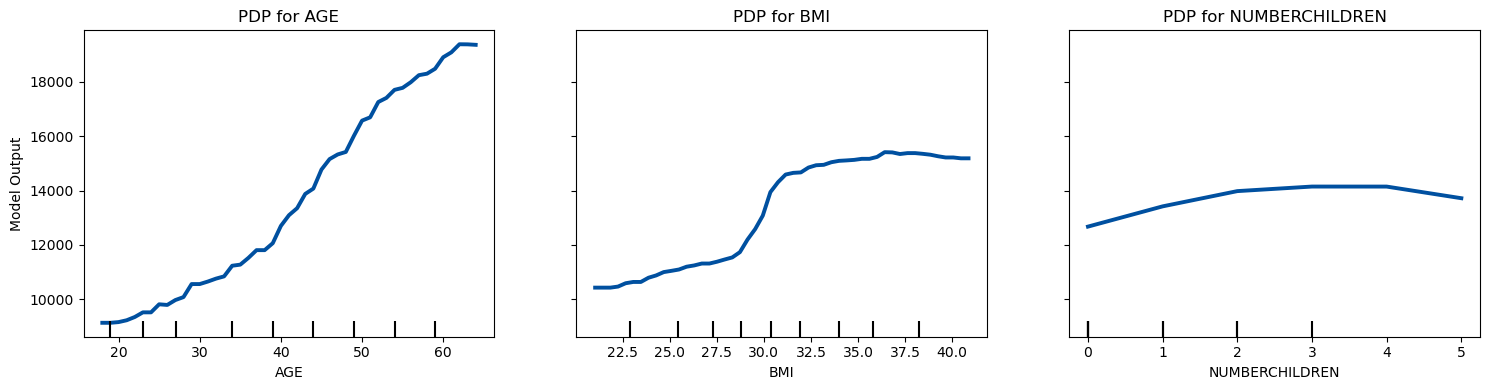

In [14]:
# Determine the positions (indices) of the numerical features in X_raw_test
feature_indices = [X_raw_test.columns.get_loc(name) for name in numerical_features]

# Create the Partial Dependence Plot (PDP)
display = PartialDependenceDisplay.from_estimator(
    model_CB_raw, X_raw_test, features=feature_indices, kind='average', n_cols=3, grid_resolution=50,
    pd_line_kw={'color': COLOR_DARK, 'linewidth': 2.8, 'linestyle': '-'}
)

# Set the figure size
display.figure_.set_size_inches(15, 4)

# Customize the display
for i, axi in enumerate(display.axes_.ravel()):
    axi.set_title(f'PDP for {numerical_features[i]}')
    axi.set_ylabel("Model Output" if i == 0 else "")  # Only add y label to the first plot for cleanliness
    axi.set_xlabel(numerical_features[i])

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

The PDPs for both `AGE` and `BMI` demonstrate a clear monotonic relationship with the model's output, indicating that as these variables increase, so does the predicted cost, albeit at different rates. Conversely, the PDP for `NUMBERCHILDREN` suggests a negligible impact on the model's predictions, as the plot reveals little to no change in the output across different values of this feature.

Next, we generate two-dimensional PDPs for the numerical variables to reveal potential interactions between feature pairs affecting the model's predictions.

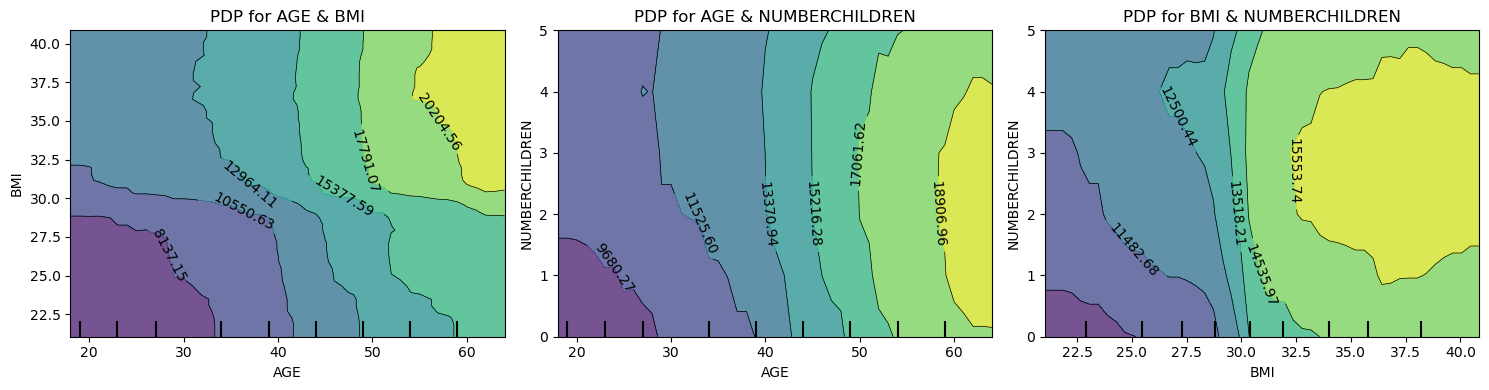

In [15]:
# Define the list of pairs of features for which to create two-dimensional PDPs
features_pairs = [('AGE', 'BMI'), ('AGE', 'NUMBERCHILDREN'), ('BMI', 'NUMBERCHILDREN')]

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 plots side by side

# Compute and plot the two-dimensional PDPs on the respective subplots
for i, feature_pair in enumerate(features_pairs):
    display = PartialDependenceDisplay.from_estimator(
        model_CB_raw, X_raw_test, features=[feature_pair],
        kind='average', n_cols=1, grid_resolution=50, ax=axs[i]
    )
    display.axes_[0, 0].set_title(f'PDP for {feature_pair[0]} & {feature_pair[1]}')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

The two-dimensional PDP of `AGE` and `BMI` shows some interactions, with the strong increase around a BMI value of 30 being less pronounced at lower `AGE` values than at higher `AGE` values. The two-dimensional PDPs also reveal that there are almost no interdependencies between `NUMBERCHILDREN` and both `AGE` and `BMI`.

Having constructed both one-dimensional and two-dimensional Partial Dependence Plots for our numerical features, we now shift our attention to the categorical variables. To gain a similar depth of insight, we will proceed to generate one-dimensional and two-dimensional PDPs for these categorical attributes as well.

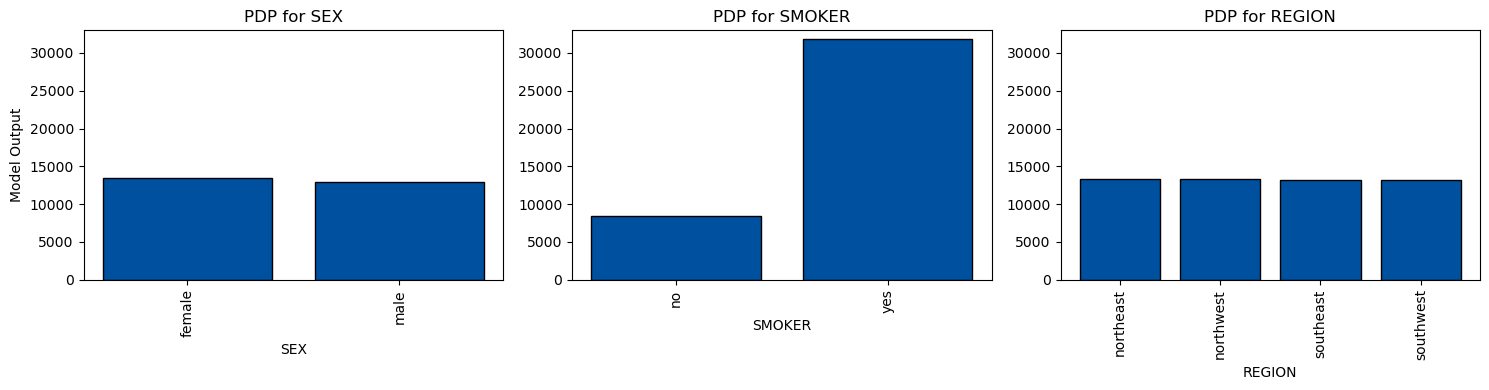

In [16]:
# Define categorical features for which we want to plot PDPs
features = ['SEX', 'SMOKER', 'REGION']
categorical_indices = [X_raw_test.columns.get_loc(f) for f in features] 

# Set up the figure for multiple subplots
fig, axs = plt.subplots(ncols=len(features), figsize=(15, 4))

# Plot partial dependence for each categorical feature
for i, (feature, ax) in enumerate(zip(features, axs.flatten())):
    display = PartialDependenceDisplay.from_estimator(
        model_CB_raw, X_raw_test, kind='average',
        features=[categorical_indices[i]], 
        categorical_features=[categorical_indices[i]], 
        feature_names=X_raw_test.columns, ax=ax
    )
    # Adjust colors
    for container in display.axes_[0][0].containers:
        for bar in container:
            bar.set_color(COLOR_DARK)
            bar.set_edgecolor('black')
    # Customize the display
    for j, axi in enumerate(display.axes_.ravel()):
        axi.set_title(f'PDP for {feature}')
        axi.set_ylim([0, 33000])
        axi.set_ylabel(
            "Model Output" if i == 0 else ""
        )  # Only add y label to the first plot
        axi.set_xlabel(feature)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

From the Partial Dependence Plots depicted above, we infer that the features `SEX` and `REGION` exhibit minimal impact on the model's predictions. Conversely, the PDP for `SMOKER` indicates that smoking status has a substantial effect on the model's output, highlighting it as an influential factor in the prediction process.

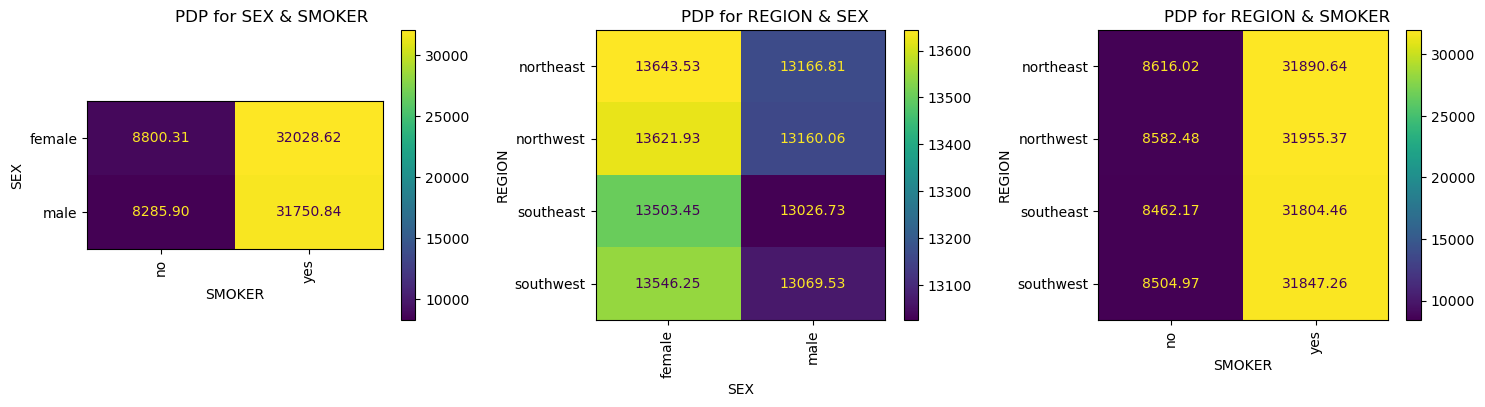

In [17]:
# Define pairs of features for which to plot 2D PDPs
feature_pairs = [('SEX', 'SMOKER'), ('REGION', 'SEX'), ('REGION', 'SMOKER')]

# Determine the column indices for categorical features
category_indices = {
    'SEX': X_raw_train.columns.get_loc('SEX'),
    'SMOKER': X_raw_train.columns.get_loc('SMOKER'),
    'REGION': X_raw_train.columns.get_loc('REGION')
}

# Set up the figure for multiple subplots
fig, axs = plt.subplots(ncols=len(feature_pairs), figsize=(15, 4))

# Plot partial dependence for each feature pair
for i, feature_pair in enumerate(feature_pairs):
    feature_indices = [category_indices[feat] for feat in feature_pair]
    display = PartialDependenceDisplay.from_estimator(
        model_CB_raw, X_raw_train, features=[feature_indices],
        categorical_features=feature_indices, kind='average', ax=axs[i],
        feature_names=X_raw_train.columns                   
    )
    display.axes_[0][0].set_aspect(0.5)
    # Set the title for each subplot
    axs[i].set_title(f'PDP for {feature_pair[0]} & {feature_pair[1]}')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

The two-dimensional Partial Dependence Plots clearly demonstrate that the `SMOKER` variable is the dominant factor affecting the model's predictions, while variables such as `SEX` and `REGION` appear to have negligible effects.

Note that while it is feasible to generate a two-dimensional PDP combining one numerical and one categorical feature, we have chosen to exclude this for the sake of brevity.

<i>Advantages and Disadvantages:</i>

At the end of this section, we list several advantages and disadvantages of Partial Dependence Plots:

<div style="background-color: #d5ffd9; border-left: 4px solid #569253; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Advantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Intuitive Visualization</u>:<br>
        Partial Dependence Plots offer a clear and accessible way to depict the relationship between a feature and the predicted outcomes, facilitating easy interpretation of complex model behaviors.</li>
        <li style="margin-bottom: 14px"><u>Non-Technical Stakeholder Engagement</u>:<br>
        PDPs provide visual explanations that can be readily presented to stakeholders without a data science background, aiding in transparent decision-making processes.</li>
        <li style="margin-bottom: 14px"><u>Feature Interaction Insights</u>:<br>
        Two-dimensional PDPs can reveal the interaction effects between pairs of features on the predicted outcome, offering a deeper understanding of how feature combinations influence model predictions.</li>
    </ul>
</div>

<div style="background-color: #ffd8d8; border-left: 4px solid #925653; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Disadvantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Assumption of Feature Independence</u>:<br>
        PDPs assume that the features are independent which is rarely the case in real-world data. This can lead to incorrect interpretations if features are correlated.</li>
        <li style="margin-bottom: 14px"><u>Creation of Unfeasible Instances</u>:<br>
        By design, PDPs can suggest interpretations based on combinations of feature values that do not occur naturally, leading to conclusions about non-existent or unfeasible instances.</li>
        <li style="margin-bottom: 14px"><u>Limited by Dimensionality</u>:<br>
        Designed for one or two features at a time, PDPs struggle in high-dimensional space where feature interactions are complex.</li>
        <li style="margin-bottom: 14px"><u>Oversimplified Representation</u>:<br>
        By averaging out the effects of all other features, PDPs can oversimplify the model behavior and may not accurately reflect the local nuances that could be captured by Individual Conditional Expectation (ICE) plots or Accumulated Local Effects (ALE) plots.</li>
    </ul>
</div>

<h1 id="subsection_ale"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    4.3 Accumulated Local Effects (ALE)
    <a class="anchor-link"
       href="#c1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<i>Main Idea:</i>

Accumulated Local Effects (ALE) plots are a tool used to understand the influence of features on model predictions by examining the 'local' rather than 'global' effects, thus capturing the nuanced variations that might not be apparent from other methods. Unlike Partial Dependence Plots (PDPs), which consider the average effect of a feature across the entire dataset and assume feature independence, ALE addresses these limitations by focusing on how small changes in feature values affect the predictions locally.

<i>Operational Details:</i>

For numerical features, ALE is calculated by partitioning the range of a feature into intervals and accumulating the differences in predictions that result from perturbing the feature within these intervals. This is done by evaluating the model with feature values slightly above and below the observed value and taking the average of these prediction changes. The local effect is then the accumulated average across these intervals for a feature.
In the case of categorical features, ALE determines the predictive effects by comparing how the model's outputs vary when the feature value switches between categories. It then integrates these variations to capture the overall influence of category changes throughout the dataset.

<i>Relation to Other XAI Methods:</i>

ALE plots provide a valuable connection between PDPs and Individual Conditional Expectation (ICE) plots. Contrasting with PDPs that examine average effects and ICE plots that detail single-instance paths, ALE furnishes a middle ground by aggregating localized changes—circumventing assumptions of feature independence and thus furnishing a more faithful representation of a feature's influence.

<i>Interpretation:</i>


Interpreting ALE plots involves examining the shape and slope of the curve. A flatter curve suggests that the feature has a minimal effect on the model's predictions within that range, while a curve with a steep slope or significant undulations indicates that the feature has a substantial effect that may vary across different values.

<i>Application to the Medical Costs Dataset:</i>

First, we examine the one-dimensional ALE plots corresponding to the numerical features in our dataset.

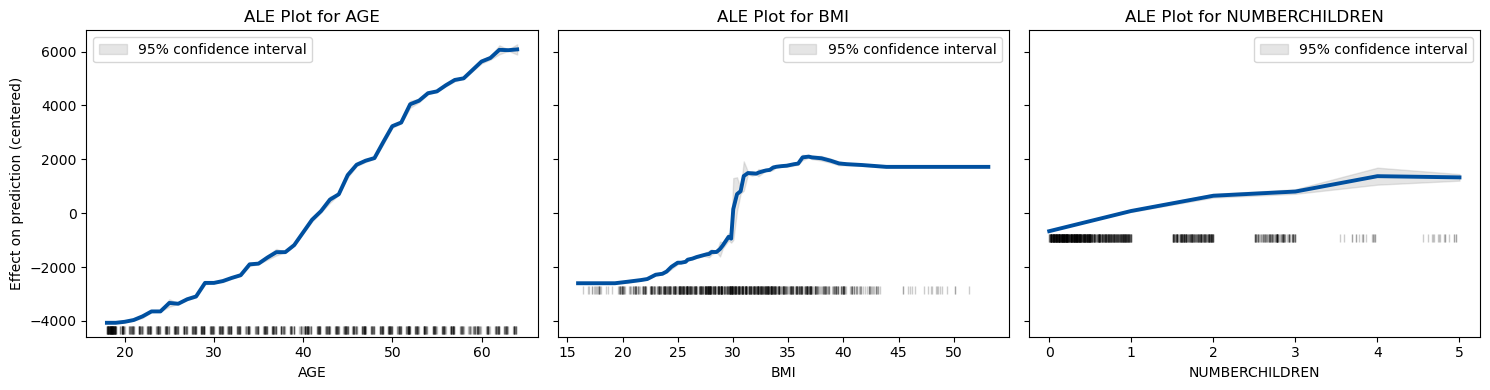

In [18]:
# List of features for which ALE plots are to be generated
features_to_plot = ['AGE', 'BMI', 'NUMBERCHILDREN']

# Set up a figure with subplots (one for each feature)
fig, axes = plt.subplots(1, len(features_to_plot), figsize=(15, 4), sharey=True)

# Generate ALE plot for each feature
for i, feature in enumerate(features_to_plot):
    ale_plot = ale(
        X=X_raw_train,        # DataFrame containing the training feature data
        model=model_CB_raw,   # Trained model
        feature=[feature],    # Feature to analyze (as a list)
        feature_type='continuous',
        grid_size=50,         # Grid size, can be set according to needs
        include_CI=True,
        fig=fig,
        ax=axes[i]            # Use the i-th axis for the plot
    )
    
    # Adjust line style and color
    axes[i].lines[0].set_color(COLOR_DARK)
    axes[i].lines[0].set_linewidth(2.8)
    
    # Set title for each subplot
    axes[i].set_title(f"ALE Plot for {feature}")
    
    # Clean up x and y labels if necessary
    if i > 0:
        axes[i].set_ylabel('')
    axes[i].set_xlabel(feature)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Observe that the scale of the ALE plots is now centered, distinguishing them from the previously reviewed Partial Dependence Plots (PDPs). Although the overall contours of the ALE plots resemble their PDP counterparts, there are notable variances: In the case of `BMI`, the ALE plot reveals a more pronounced incline around a BMI of 30 and displays a downward trend beginning at 37, contrasting with the nearly monotonically increasing curve of the PDP. Furthermore, the ALE plot for `NUMBERCHILDREN` differs as it does not exhibit the reduction between 4 and 5 children that is apparent in the PDP.

Lastly, we visualize the interactions between selected feature pairs using two-dimensional ALE plots.

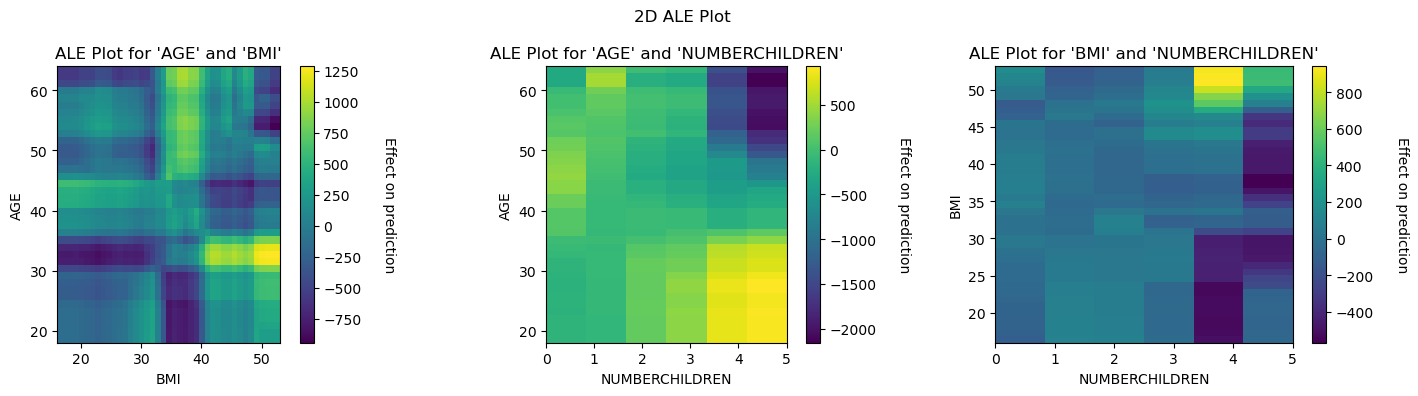

In [19]:
# Define feature pairs to plot
feature_pairs = [
    ('AGE', 'BMI'), 
    ('AGE', 'NUMBERCHILDREN'), 
    ('BMI', 'NUMBERCHILDREN')
]

# Set up a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Iterate over feature pairs and axes to create ALE plots
for i, (feature1, feature2) in enumerate(feature_pairs):
    # Use the ale function, providing the corresponding ax
    ale_plot = ale(
        X=X_raw_train,                # DataFrame containing the training data
        model=model_CB_raw,           # Trained model
        feature=[feature1, feature2], # Feature pair to analyze
        grid_size=40,                 # Grid size, can be set according to needs
        include_CI=False,
        fig=fig,
        ax=axes[i]                    # Use the i-th axis for the plot
    )
    axes[i].set_aspect(0.125 if i != 0 else 1)
    # Set the title for each subplot
    axes[i].set_title(f"ALE Plot for '{feature1}' and '{feature2}'")

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.show()

The two-dimensional ALE plot for the `AGE` and `BMI` interaction highlights two specific negative impact zones on predicted costs: individuals around thirty with BMIs under 30, and younger individuals with BMIs in the mid-thirties. The ALE plots for interactions with `NUMBERCHILDREN` show less influence on predictions, with notable effects only in sparse data regions associated with high child counts.

Please note that for brevity, we have omitted the inclusion of both one-dimensional and two-dimensional ALE plots for categorical features, as well as combined two-dimensional ALE plots that involve one numerical and one categorical feature.

<i>Advantages and Disadvantages:</i>

At the end of this section, we list several advantages and disadvantages of Accumulated Local Effects:

<div style="background-color: #d5ffd9; border-left: 4px solid #569253; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Advantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Handles Feature Dependency</u>:<br>
        Unlike Partial Dependence Plots (PDPs), ALE plots take into account the potential interactions among features by focusing on local effects of features, thus providing more accurate representations when features are correlated.</li>
        <li style="margin-bottom: 14px"><u>Reduced Computational Cost</u>:<br>
        ALE plots require fewer computations than PDPs when dealing with high-cardinality categorical features or continuous features, because they do not have to average predictions across all possible values of other features.</li>
        <li style="margin-bottom: 14px"><u>Localized Interpretations</u>:<br>
        ALE plots provide insights into the effects of features on predictions in different regions of the feature space, which can be more informative about the actual operation of the model in specific localized areas, compared to the more global perspective of PDPs.</li>
    </ul>
</div>

<div style="background-color: #ffd8d8; border-left: 4px solid #925653; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Disadvantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>More Complex Interpretation</u>:<br>
        The locality of the effects displayed by ALE plots can be less straightforward to interpret than the global average effects shown in PDPs, especially for non-technical stakeholders.</li>
        <li style="margin-bottom: 14px"><u>Potentially Misleading with Sparse Data</u>:<br>
        In regions of the feature space where data is sparse, ALE estimates might be unreliable due to the lack of sufficient data to calculate accurate local accumulated effects.</li>
        <li style="margin-bottom: 14px"><u>Dimensionality Constraints</u>:<br>
        Similar to PDPs, ALE plots are primarily useful for visualizing one or two features at a time, and they may not effectively communicate the presence of complex multidimensional interactions.</li>
        <li style="margin-bottom: 14px"><u>Lack of Individual Variation Insights</u>:<br>
        Unlike PDPs, ALE plots are not accompanied by ICE curves and therefore it is hard to dectect heterogeneity in the feature effect.</li>
    </ul>
</div>

<h1 id="subsection_pfi"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    4.4 Permutation Feature Importance (PFI)
    <a class="anchor-link"
       href="#c1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<i>Main Idea:</i>

Feature importances play a crucial role in understanding the decision-making process of machine learning models by identifying how much each feature contributes to the model's predictions. This information is valuable not only for interpreting the model but also for feature engineering and feature selection for future model iterations. Permutation Feature Importance (PFI) is a model-agnostic technique used to measure the importance of a feature by calculating the decrease in the model's performance when that feature's values are shuffled, thereby breaking the relationship between the feature and the outcome.

<i>Operational Details:</i>

PFI is calculated using the following method for both numerical and categorical variables. The process involves the following steps, repeated for each feature separately:

1. The model is initially evaluated on a dataset to establish a baseline performance score, using a metric such as RMSE or $R^2$ score.

2. For the feature under consideration, the values are permuted in the dataset—randomly shuffled to disrupt the correlation between that feature and the target—and the model is re-evaluated on this perturbed dataset. The performance decrease, as compared to the baseline, is recorded as the importance score for the feature.

3. The permutation and evaluation process is typically repeated multiple times for each feature to obtain a reliable estimate of feature importance, and the average drop in performance is calculated.

The following picture provides a visual illustration of the three steps outlined above for calculating the PFI of the feature `BMI`.

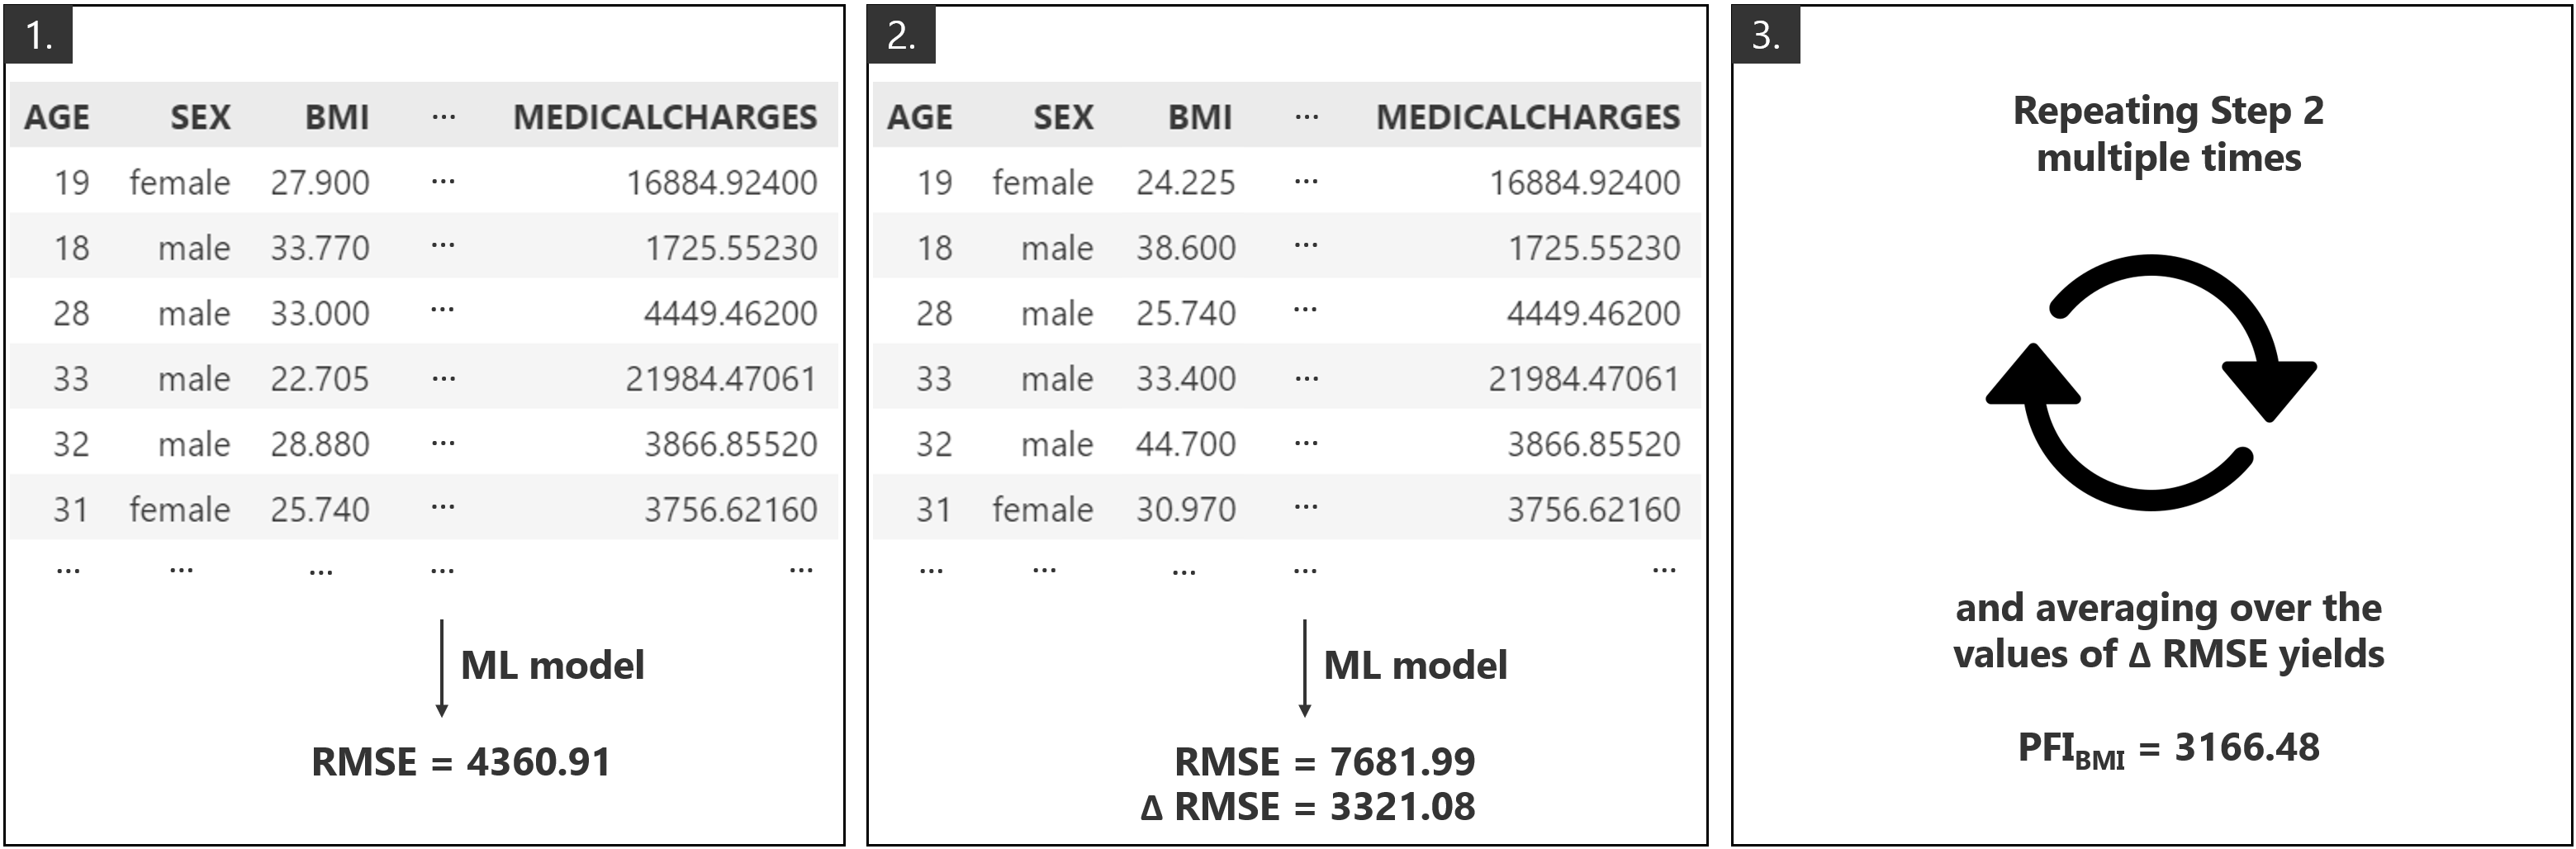

<i>Interpretation:</i>

The heuristic interpretation of PFI results is as follows: A notable decrease in the model's performance indicates that the feature is significant for the model's predictive accuracy. Conversely, a minor or insubstantial decrease points to a feature being non-essential. An advantage of PFI is its simplicity and applicability to any model, regardless of its complexity. However, it is essential to note that PFI can be sensitive to data leakage or features that are artificially over-represented. It can also fail to detect interactions between features since it evaluates them in isolation.

<div style="background-color: #f2f2f2; border-left: 4px solid #888888; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
<p style="font-weight: bold"><b>Actuarial Diligence Note</b></p>
<p style="margin-bottom: 10px;">

When implementing permutation feature importance (PFI), one has to be aware of its fundamental assumption that shuffling a feature's values does not impact the distribution of other features. This assumption can be problematic in real-world datasets where features are often correlated, potentially leading to misleading interpretations. To ensure robustness in the conclusions drawn from PFI, it is advisable to compare its outcomes with other feature importance measures. This could include models' internal feature importances (if existent), like those within CatBoost, feature importances derived from SHAP (see [Subsection 5.1](#subsection_SHAP)), or other relevant methods. These additional methods, which typically take into account the model's structure, can provide contrasting importance rankings and thus a more comprehensive understanding of feature significance. For a detailed comparison using the medical costs dataset, refer to [Subsection A.3](#subsection_a3).
</p>
</div>

<i>Application to the Medical Costs Dataset:</i>

The code snippet below demonstrates the application of PFI on our medical costs dataset.

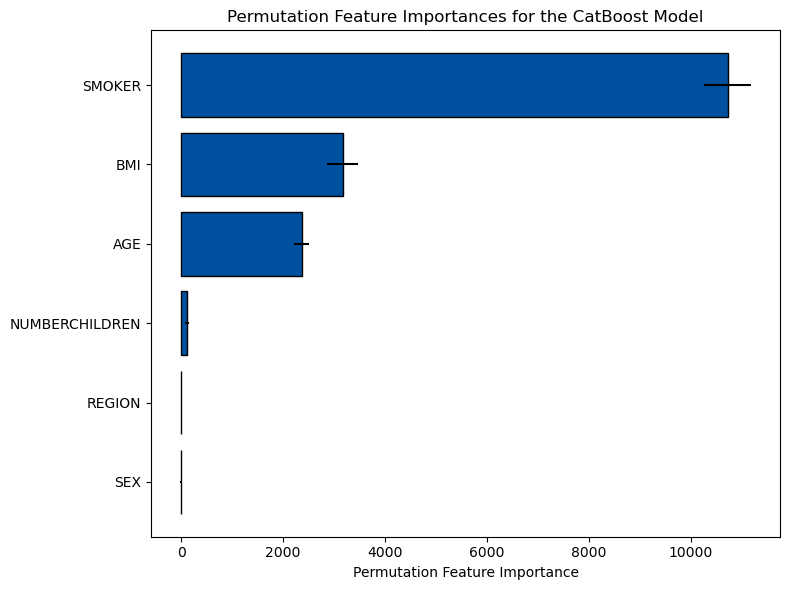

In [20]:
# Perform permutation feature importance
results = permutation_importance(
    model_CB_raw, X_raw_test, y_test,
    scoring='neg_root_mean_squared_error',  # Metric for scoring permutations
    n_repeats=1000,                         # Number of times to permute a feature
    random_state=RANDOM_SEED                # The random seed for reproducibility
)

# Sort feature importances in descending order and get their indices
sorted_idx = results.importances_mean.argsort()

# Get the standard deviations for the sorted features
sorted_std = results.importances_std[sorted_idx]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    range(len(sorted_idx)),
    results.importances_mean[sorted_idx],
    color=COLOR_DARK,
    edgecolor='black',
    xerr=sorted_std  # Include empirical standard errors
)
plt.yticks(
    range(len(sorted_idx)), 
    [X_raw_test.columns[i] for i in sorted_idx]
)
plt.xlabel("Permutation Feature Importance")
plt.title("Permutation Feature Importances for the CatBoost Model")
plt.tight_layout()
plt.show()

Confirming findings from the initial exploratory data analysis, the permutation feature importance underscores that `SMOKER` status is the dominant feature, wielding the highest predictive influence. The subsequent features, `BMI` and `AGE`, are also critical to the model's predictions. In contrast, the remaining attributes—`NUMBERCHILDREN`, `REGION`, and `SEX`—are shown to have little to no effect on the predictive outcome.

<i>Advantages and Disadvantages:</i>

At the end of this section, we list several advantages and disadvantages of Permutation Feature Importance:

<div style="background-color: #d5ffd9; border-left: 4px solid #569253; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Advantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Intuitive Interpretation</u>:<br>
        The method is straightforward to understand – features that impact the model performance more significantly when permuted are considered more important.</li>
        <li style="margin-bottom: 14px"><u>No Assumptions About Data</u>:<br>
        PFI does not rely on any assumptions about the model or data being linear, normally distributed, or independent.</li>
        <li style="margin-bottom: 14px"><u>Useful for Feature Selection</u>:<br>
        Permutation feature importance can be used as a tool for feature selection by identifying the features that do not contribute significantly to the model's predictive power.</li>
    </ul>
</div>

<div style="background-color: #ffd8d8; border-left: 4px solid #925653; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Disadvantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Impact of Correlated Features</u>:<br>
        When features are correlated, permuting one feature can also indirectly affect the importance of another, which can lead to misinterpreting feature importance.</li>
        <li style="margin-bottom: 14px"><u>Generation of Unrealistic Data</u>:<br>
        The shuffling of values to assess importance can result in the generation of improbable or impossible data combinations, which can in turn affect the reliability of the importance measurements.</li>
        <li style="margin-bottom: 14px"><u>Computationally Expensive</u>:<br>
        For models that are slow to predict or datasets that are large, computing PFI can be computationally expensive because it involves re-evaluating the model multiple times.</li>
        <li style="margin-bottom: 14px"><u>Does Not Account for Model Internals</u>:<br>
        Permutation feature importance is purely based on changes in model performance without considering the internal structure or coefficients of the model that might give more insight into how features are used by the model.</li>
        <li style="margin-bottom: 14px"><u>Randomness in Importance Scores</u>:<br>
        The randomness introduced by permuting features can sometimes lead to variability in importance scores across multiple runs, especially when the dataset is small or the model is very complex.</li>
    </ul>
</div>

<h1 id="section_local" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">5. Local Model-Agnostic Explainability Methods</h1>

In Section 5, we examine <i>local</i> model-agnostic explainability methods, where the objective is to understand the decision-making process of machine learning models at an individual prediction level. Such methods can, for instance, provide insights into how each feature affects a single prediction, or they may illuminate the localized behavior of the model in the area surrounding a specific instance. We focus on the key techniques Shapley Additive Explanations (SHAP), Local Interpretable Model-Agnostic Explanations (LIME), and Individual Conditional Expectation (ICE) plots.

Throughout this section, our goal is to detail the model's decision-making process for the following particular entry within our medical cost dataset:

In [29]:
# Instance of interest
observation_index = 4

# Combine the independent features and the prediction into one DataFrame
observation_features = X_raw_test.iloc[[observation_index]]
observation_prediction = model_CB_raw.predict(observation_features).item()
observation_combined = observation_features.assign(
    MEDICALCHARGES_predicted = observation_prediction
)

# Display the combined information as one line
observation_combined

,AGE,SEX,BMI,NUMBERCHILDREN,SMOKER,REGION,MEDICALCHARGES_predicted
484,48,male,34.3,3,no,southwest,11443.273135


<h1 id="subsection_shap"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    5.1 Shapley Additive Explanations (SHAP)
    <a class="anchor-link"
       href="#c1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<i>Main Idea:</i>

Shapley Additive Explanations (SHAP) is a powerful XAI method inspired by cooperative game theory that provides a way to explain the output of machine learning models. It assigns each feature an importance value for a particular prediction by simulating a "game" where each feature value of the instance is considered a "player" and the prediction is the "payout". SHAP values are calculated by averaging the marginal contributions of a feature across all possible combinations of features (see below). This framework ensures that SHAP values are—according to Shapley's fairness criteria—fairly distributed among the features and the sum of SHAP values explains why the model's output deviates from the baseline prediction.

<i>Operational Details:</i>

The Shapley value $\phi_i$ for the $i$-th feature value is computed as follows:

$$ \phi_i(f,x) = \sum_{S \subseteq N \backslash \{i\}} \underbrace{\frac{|S|!(|N|-|S|-1)!}{|N|!}}_{\text{Shapley weight}} \cdot \underbrace{\Big[ f_x(S \cup \{i\}) - f_x(S) \Big]}_{\text{marginal contribution of $i$-th feature}} $$

In the formula above, we have:
- $f$ is our machine learning model.
- $x$ is the specific instance for which we want to compute the SHAP values.
- $N$ is the set of all features.
- $S$ is a subset of features excluding the $i$-th feature.
- $|S|$ is the number of features in the subset $S$.
- $|N|$ is the total number of features.
- $f_x(S)$ is the prediction made by the model using the features in $S$ and the baseline values for all other features.

For an in-depth understanding of the technical aspects and methodology behind computing SHAP values, particularly the calculation of a feature's marginal contribution, readers are encouraged to consult [2] for detailed analysis.

The SHAP values for each feature sum up to the difference between the prediction for the input $x$ and the average prediction across all data points:

$$ f(x) = \text{mean prediction} + \sum_{i \in N} \phi_i(f,x) $$

<div style="background-color: #f2f2f2; border-left: 4px solid #888888; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <p style="font-weight: bold"><b>Actuarial Diligence Note</b></p>
    <p style="margin-bottom: 10px;">The computation of Shapley values is inherently computationally expensive due to the necessity to evaluate the model’s prediction for all possible feature subset combinations. This complexity grows factorially with the number of features, making exact calculations impractical for models with a substantial number of features. To address this challenge, various approximation methods have been developed. KernelSHAP employs a weighted linear regression to approximate SHAP values, offering a trade-off between accuracy and computational efficiency and allowing for application to any model. TreeSHAP, on the other hand, is designed specifically for tree-based models and leverages the internal structure of decision trees to compute exact SHAP values much more efficiently. These specialized approaches reduce computational load and make the application of SHAP values feasible in practical scenarios, while still adhering to the original Shapley value properties.
        
For a detailed examination of the nuanced differences between various SHAP value approximation techniques as applied to our medical costs dataset, please see [Subsection A.3](#subsection_actuarialdiligenceSHAP), which offers a critical analysis of how these approximations impact our results.
</p>
</div>

<i>Interpretation:</i>

Interpreting SHAP values provides both global and local insights. Locally, one can look at the SHAP values for each feature of a single prediction to understand how much each feature contributed to the prediction and in what direction. A positive SHAP value for a feature implies that this feature pushed the model's prediction higher, while a negative value would imply the opposite. Globally, aggregating SHAP values over a dataset can provide insights into feature importance, showing which features have more impact on the model's predictions across all data points. Furthermore, SHAP values can also be utilized highlight interactions between features. SHAP interaction values quantify not only the individual impact of each feature but also the combined effects of feature pairs on the prediction. This allows for an understanding of how features influence the model's output in synergy, providing a more complete picture of the relationships within the data.

<i>Application to the Medical Costs Dataset:</i>

Below, we will compute (an approximation of) the Shapley values utilizing the `KernelExplainer` from the `shap` library. While this method is thorough, it is computationally intensive. Alternative faster approaches, such as the `TreeExplainer` detailed subsequently, are available but may encounter different challenges.

In [22]:
# Create a SHAP KernelExplainer using the training set
explainer = shap.KernelExplainer(model_CB_raw.predict, X_raw_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_raw_test)

shap:WARNING: Using 936 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 402/402 [02:28<00:00,  2.71it/s]


The subsequent code will generate a SHAP waterfall plot, which visually represents the contribution of each feature to a specific prediction. Beginning with the base value—the model's average prediction—the plot stacks each feature's effect, with positive impacts extending to the right (in red) and negative ones to the left (in blue). To interpret the plot, start from the base value and follow the features' contributions upwards to arrive at the final model prediction at the top.

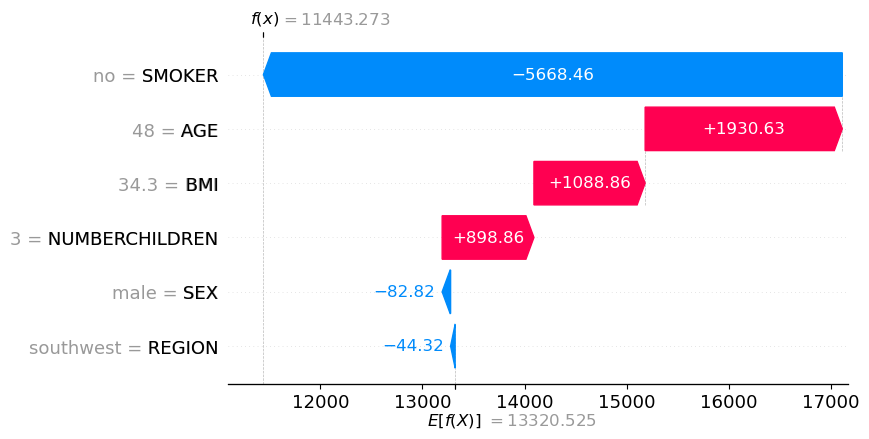

In [33]:
# Create an Explanation object for the particular instance of interest
explanation = shap.Explanation(values=shap_values[observation_index],
                               base_values=explainer.expected_value,
                               data=X_raw_test.iloc[observation_index])

# Display the SHAP waterfall plot
shap.waterfall_plot(explanation)

From the SHAP waterfall plot above, we can see that our specific prediction of 11443.273 breaks down into the model's average guess of 13320.525, plus or minus the effects of different features. For the observed individual, not being a `SMOKER` greatly lowers the predicted costs. On the other hand, being older, having a higher `BMI`, and having more children increase the costs. Features like `SEX` and `REGION`, however, seem to have almost no impact on this particular prediction.

SHAP's local interpretations can be aggregated to provide a global perspective on explainability. The upcoming figure features a SHAP summary plot on the right, wherein the SHAP values of all instances are plotted together. By taking the absolute values of these SHAP values and computing their average, we obtain a measure of feature importance for each feature. On the left side of the figure, we present a plot that displays these aggregated feature importances across all features. This approach facilitates a comprehensive understanding of the most influential factors in the model.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


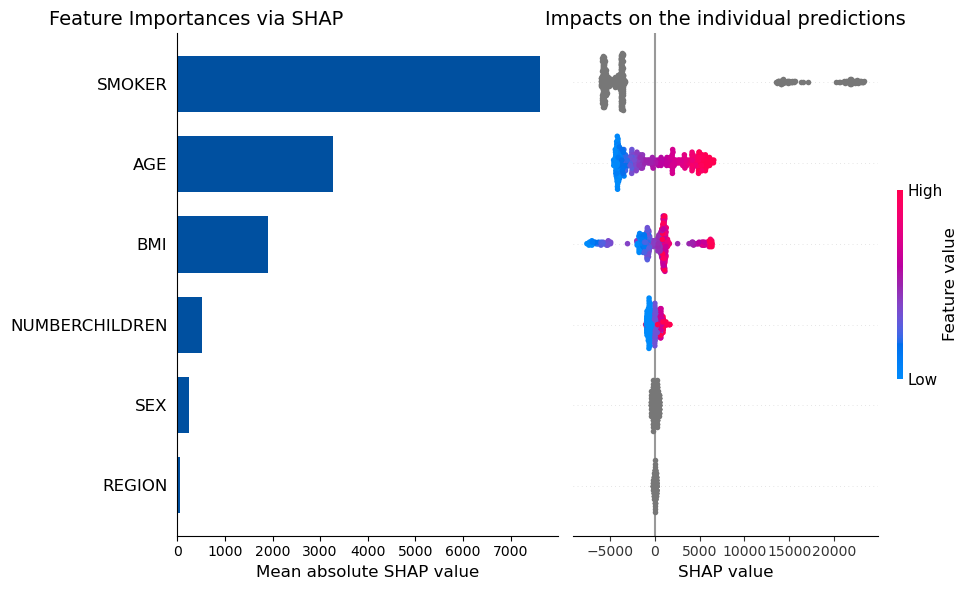

In [34]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(0)

fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.bar_plot(mean_abs_shap_values, feature_names=X_raw_test.columns, 
              show=False)
# Change the colormap of the artists
for fc in plt.gcf().get_children():
    # Ignore last Rectangle
    for fcc in fc.get_children()[:-1]:
        if isinstance(fcc, matplotlib.patches.Rectangle):
            if matplotlib.colors.to_hex(fcc.get_facecolor()) == "#ff0051":
                fcc.set_facecolor(COLOR_DARK)
        elif isinstance(fcc, plt.Text):
            if matplotlib.colors.to_hex(fcc.get_color()) == "#ff0051":
                fcc.set_color(COLOR_DARK)
title_obj = plt.title('Feature Importances via SHAP', fontsize=14)
# Get the current position of the title
pos = title_obj.get_position()
# Horizontally shift the title to the left 
# (e.g., 10% of the way across the figure from the left edge)
# pos is a tuple (x, y), we only change the x-coordinate here
title_obj.set_position([0.0495, pos[1]])
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=12)
plt.xlabel('Mean absolute SHAP value', fontsize=12)
ax1 = fig.add_subplot(122)
shap.summary_plot(shap_values, X_raw_test, show=False)
plt.gcf().axes[-1].set_aspect(30)
plt.title('Impacts on the individual predictions', fontsize=14)
plt.xlabel('SHAP value', fontsize=12)
ax1.tick_params(axis='x', labelsize=10)
ax1.set_yticklabels([])
ax1.set_ylim(-0.61, 5.6) 
plt.gcf().set_size_inches(10, 6)
plt.tight_layout() 
plt.show()

Echoing the findings from Permutation Feature Importance examined in [Subsection 4.4](#subsection_pfi), the feature `SMOKER` emerges as the most influential in affecting our model's predictions. It is followed in significance by `AGE` and `BMI`, which likewise contribute notably to the model's decision-making process.

Next, we turn to SHAP dependence plots, a valuable tool for examining the effect of a single feature on model predictions and pinpointing potential interactions with other features. We use this plot type to analyze how the `BMI` feature impacts medical cost predictions from our CatBoost model and investigate if this effect varies with the `SMOKER` status. The code below produces a dependence plot for `BMI`, with data points colored based on `SMOKER` values, offering insight into the interaction between these two features.

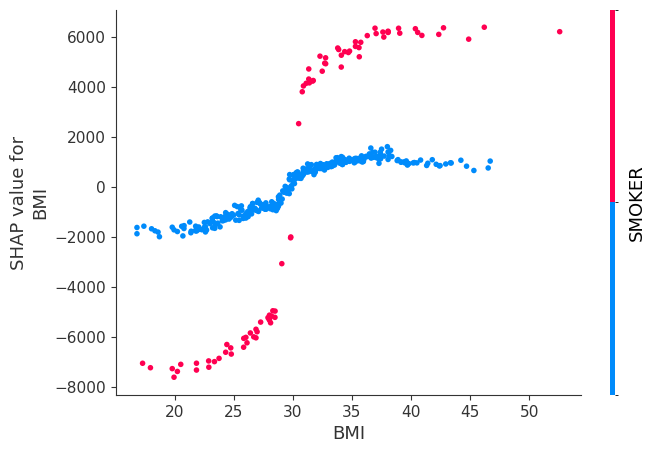

In [35]:
# Create and display the SHAP dependence plot for 'BMI' and 'SMOKER'
shap.dependence_plot('BMI', shap_values, X_raw_test, interaction_index='SMOKER')

The SHAP dependence plot clearly illustrates that for individuals identified as smokers (`SMOKER` status 'yes', colored in red), the SHAP values for `BMI` exhibit a considerably sharper upward trend once BMI exceeds 30, in comparison to non-smoking individuals. This suggests that being a smoker amplifies the influence of higher BMI on the predicted medical costs.

<i>Advantages and Disadvantages:</i>

At the end of this section, we list several advantages and disadvantages of SHAP:

<div style="background-color: #d5ffd9; border-left: 4px solid #569253; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Advantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Strong Theoretical Fundament</u>:<br>
        SHAP values adhere to a consistent attribution of contributions across features, drawing from cooperative game theory to provide a fair and stable distribution of predictive 'credits'.</li>
        <li style="margin-bottom: 14px"><u>Detailed Insights for Individual Predictions</u>:<br>
        SHAP allows for a deep dive into the decision-making process for individual data points, offering specific, nuanced explanations rather than broad generalizations.</li>
        <li style="margin-bottom: 14px"><u>Intuitive Visualizations</u>:<br>
        SHAP's visual tools, like the waterfall plot, provide clear and intuitive visual representations of feature contributions, facilitating easier communication and understanding of model behavior for various audiences.</li>
        <li style="margin-bottom: 14px"><u>Local to Global Explainability</u>:<br>
        While SHAP provides explanations for individual predictions, these local explanations can be aggregated to quantify global feature importance, offering insights into the model’s overall behavior.</li>
    </ul>
</div>

<div style="background-color: #ffd8d8; border-left: 4px solid #925653; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Disadvantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Computational Intensity</u>:<br>
        Computing SHAP values, especially with methods like `KernelExplainer`, can be computationally expensive, posing challenges with large datasets or complex models.</li>
        <li style="margin-bottom: 14px"><u>Complexity for End-Users</u>:<br>
        While visualizations are intuitive, the underlying concept of SHAP and the interpretation of individual contributions can be complex for end-users without a technical background.</li>
    </ul>
</div>

<h1 id="subsection_lime"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    5.2 Local Interpretable Model-Agnostic Explanations (LIME)
    <a class="anchor-link"
       href="#c1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<i>Main Idea:</i>

Local Interpretable Model-Agnostic Explanations (LIME) is an Explainable AI method designed to help data scientists understand and trust the predictions made by complex machine learning models. The core idea of LIME is to approximate a given black box model locally by an interpretable model that is easier to understand. By doing so, LIME provides explanations for individual predictions (local explanations), revealing which features are most important for the model's decision in a neighborhood of the particular instance of interest.

<i>Operational Details:</i>

The calculation process for a LIME explanation involves several steps. Given an instance for which we want an explanation, LIME generates a set of new samples around the instance by perturbing the feature values. It then applies the complex model to these new samples to calculate the corresponding predictions. Next, it weighs these samples according to their proximity to the original instance – samples that are more similar to the original instance have a larger influence. LIME then fits an interpretable model, such as a linear regression or a decision tree, to the new samples using the calculated predictions and weights. The interpretable model aims to mimic the complex model's behavior in a neighborhood of the instance being explained. The coefficients or structure of this simple model offer insights into which features have the greatest impact on the prediction.

<i>Interpretation:</i>

Interpreting the output of LIME on basis of a linear regression typically involves looking at the coefficients of the underlying linear model. In such a case, each coefficient represents the contribution of the corresponding feature to the prediction for the instance at hand. A positive coefficient indicates a feature that contributes to increasing the prediction value, while a negative coefficient indicates a feature that contributes to decreasing it. The magnitude of the coefficient reflects the strength of the feature's influence. Hence, LIME allows us to derive an understanding of why a (black box) model made a certain prediction. While LIME provides valuable insights into individual predictions, it is important to remember that the explanations are local; different models or even slightly different instances can lead to different explanations. Therefore, LIME is best used to explore the model behavior around specific predictions, rather than to derive global conclusions about the model's behavior.

<i>Application to the Medical Costs Dataset:</i>

The `lime` packages used below for the application of LIME requires the input data to be label encoded. As a first step, we hence employ label encoding on our dataset.

In [36]:
# Encode categorical features using LabelEncoder
label_encoders = {
    feature: LabelEncoder().fit(df_raw[feature])
    for feature in categorical_features
}

# Function to transform the dataset using the encoders and inverse transform it
def transform_data(df, label_encoders, inverse=False):
    df_transformed = df.copy()
    for feature, le in label_encoders.items():
        if inverse:
            # Manually reverse the transformation to handle unseen labels
            mapping = dict(zip(le.transform(le.classes_), le.classes_))
            df_transformed[feature] = df_transformed[feature].apply(
                lambda x: mapping.get(x, x)
            )
        else:
            try:
                df_transformed[feature] = le.transform(df_transformed[feature])
            except ValueError as e:  # Catch the exception for unseen labels
                # Handle unseen labels - to be determined based on requirements
                pass
    return df_transformed

# Transform categorical features of the raw dataframe
df_labelenc = transform_data(df_raw, label_encoders)

# Drop the target column to obtain the features DataFrame
X_labelenc = df_labelenc.drop(target, axis=1)

# Create the categorical_names dict with the proper format
categorical_names = {}
categorical_features_indices = []
for feature in categorical_features:
    le = label_encoders[feature]  # Get the LabelEncoder for the feature
    feature_index = X_labelenc.columns.get_loc(feature)  # Get feature index
    categorical_features_indices.append(feature_index)
    categorical_names[feature_index] = dict(
        zip(le.transform(le.classes_), le.classes_)
    )

# Use the same train-test split as before
X_labelenc_train, X_labelenc_test, _, _ = train_test_split(
    X_labelenc, y, train_size=TRAIN_RATIO, random_state=RANDOM_SEED
)

Next, we apply LIME to obain an explanation of the considered intance of interest.

In [37]:
# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    X_labelenc_train.values,
    feature_names=X_labelenc.columns.tolist(),
    mode='regression',
    categorical_features=categorical_features_indices,
    categorical_names=categorical_names,
    kernel_width=3
)

# Create a function to predict with CatBoost on the LIME format data
def predict_fn(data_array):
    data_df = pd.DataFrame(data_array, columns=X_labelenc_test.columns)
    # Inverse transform the categorical features before prediction
    retransformed_df = transform_data(data_df, label_encoders, inverse=True)
    predictions = model_CB_raw.predict(retransformed_df).astype(float)
    return predictions

# Apply LIME on a particular instance from the test set
exp = explainer.explain_instance(
    X_labelenc_test.iloc[observation_index].values, predict_fn
)
exp.show_in_notebook(show_all=True)

The LIME analysis for this particular instance indicates that being a non-`SMOKER` notably reduces the predicted medical costs, whereas a higher `BMI`, being of middle `AGE`, and having more children are factors contributing to an increase in the model's cost predictions. `SEX` and the `REGION`, on the other hand, show negligible effects on the predicted outcome for this individual.

<i>Advantages and Disadvantages:</i>

At the end of this section, we list several advantages and disadvantages of LIME:

<div style="background-color: #d5ffd9; border-left: 4px solid #569253; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Advantages:</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Interpretable Explanations for Individual Predictions</u>:<br>
        LIME provides intuitive and comprehensible explanations for predictions, which allows users to understand why a particular prediction was made by the model, even if the underlying model is highly complex.</li>
        <li style="margin-bottom: 14px"><u>Flexibility for Different Types of Data</u>:<br>
        LIME can be applied to a variety of data types, including tabular data, text, and images, making it useful for a wide range of applications.</li>
    </ul>
</div>

<div style="background-color: #ffd8d8; border-left: 4px solid #925653; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Disadvantages:</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Local Approximations May Not Capture Global Behavior</u>:<br>
        LIME focuses on local explanations and thus might not accurately represent the model's behavior globally or on other instances beyond the one being explained.</li>
        <li style="margin-bottom: 14px"><u>Dependency on Perturbation Strategy</u>:<br>
        The quality of LIME explanations can greatly depend on how the data is perturbed, which can introduce variability in the explanations.</li>
        <li style="margin-bottom: 14px"><u>Computational Complexity</u>:<br>
        Generating explanations for individual predictions can be computationally expensive, especially for very large datasets or in cases where explanations are required in real time.</li>
    </ul>
</div>

<h1 id="subsection_ice"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    5.3 Individual Conditional Expectation (ICE)
    <a class="anchor-link"
       href="#c1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

<i>Main Idea:</i>

Individual Conditional Expectation (ICE) plots offer a detailed view on the relationship between a feature of interest and model predictions for individual instances. While Partial Dependence Plots (PDPs) provide an averaged view across the dataset, ICE plots drill down to how the model's prediction changes for an individual observation when the feature value changes, keeping all other features for that instance constant. ICE plots are particularly useful for uncovering interactions and heterogeneity of feature effects that PDPs might obscure due to averaging.

<i>Operational Details:</i>

The calculation of ICE plots involves the following process: For a specific data instance, we vary the feature of interest over its range while keeping all other features fixed at their original values. We then compute the prediction for each of these modified instances. Repeating this for the entire range of the feature's values, we trace out a curve (or line in the plot) that shows how the prediction changes with the feature values for that instance. An ICE plot consists of one such line for each instance in the dataset—or for a representative sample if the dataset is very large—resulting in multiple lines overlaying each other in the plot.

<i>Relation to Other XAI Methods:</i>

The methods ICE and PDP are closely related; PDP can be considered as the average of the ICE plot lines. An Individual Conditional Expectation plot tracks the dependence of the prediction on a feature for each instance separately, while a Partial Dependence Plot averages these individual dependencies. This aggregation that PDP employs may mask variations among individual predicted outcomes that ICE can reveal. As a general rule, PDPs are suited for identifying the average effect of a feature on the predictions, while ICE plots are better for detecting the variability of this effect across individual instances. Together, ICE and PDP provide complementary insights into model behavior: PDPs for the global average effect and ICE plots for the local, case-specific effects.

<i>Interpretation:</i>

When interpreting ICE plots, each line represents the predicted outcome for a particular instance as the value of the feature of interest varies. On the $y$-axis, we have the predicted outcome, and the $x$-axis represents the values of the feature of interest. A steep slope in an individual line suggests a strong sensitivity of the prediction to the feature for that specific instance. Diverging lines across the plot can indicate potential interactions between the variable of interest and other variables, or they might reveal that the model behaves differently for different subsets of the data. A bundle of lines moving together in a consistent fashion suggests a relatively uniform effect of the feature across the instances.

<i>Application to the Medical Costs Dataset:</i>

We demonstrate ICE plots for the numerical features in our dataset. Additionally, the respective pointwise average of the ICE plots is also displayed, which coincides with the PDP. 

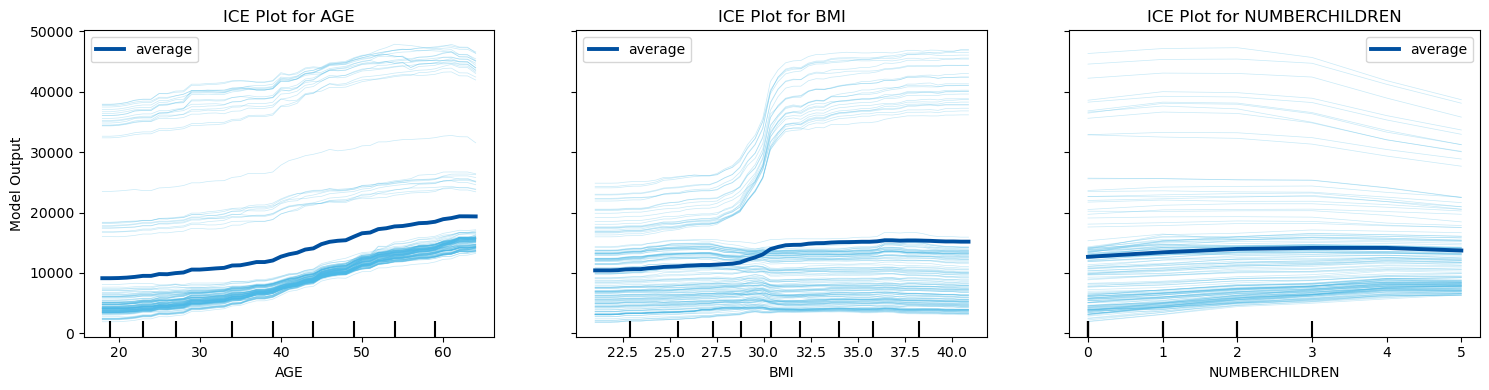

In [38]:
# Determine the positions (indices) of the numerical features in X_raw_test
feature_indices = [
    X_raw_test.columns.get_loc(name) for name in numerical_features
]

# Create the Partial Dependence Plot (PDP)
display = PartialDependenceDisplay.from_estimator(
    model_CB_raw, X_raw_test, features=feature_indices, kind='both',
    n_cols=3, grid_resolution=50, subsample=0.4,
    pd_line_kw={'color': COLOR_DARK, 'linewidth': 2.8, 'linestyle': '-'},
    ice_lines_kw={'color': COLOR_LIGHT}
)

# Set the figure size
display.figure_.set_size_inches(15, 4)

# Customize the display
for i, axi in enumerate(display.axes_.ravel()):
    axi.set_title(f'ICE Plot for {numerical_features[i]}')
    axi.set_ylabel("Model Output" if i == 0 else "")
    axi.set_xlabel(numerical_features[i])

plt.tight_layout()
plt.show()

The ICE plot for `AGE` displays a consistent monotonic relationship, indicating that the impact of age on the model's predictions is stable across different instances.
For `BMI`, the ICE plot shows two behaviors: some instances have negligible changes in predictions with varying BMI, whereas for others, predictions increase significantly when BMI exceeds 30. This suggests an interaction effect, potentially with the `SMOKER` feature.
The `NUMBERCHILDREN` plot shows no clear pattern, with the effect of the number of children on predictions varying between instances. This variability indicates complex interactions with other variables, leading to mixed effects on the model's output.

ICE plots for categorical features are omitted due to the lack of support in PartialDependenceDisplay and to maintain focus on key concepts.

<i>Advantages and Disadvantages:</i>

At the end of this section, we list several advantages and disadvantages of ICE:

<div style="background-color: #d5ffd9; border-left: 4px solid #569253; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Advantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Visualizes Individual Predictive Paths</u>:<br>
        Each line on an ICE plot corresponds to the predictive path of an individual instance across a range of feature values, enabling the analysis of predictions at the individual level rather than at an aggregated level.</li>
        <li style="margin-bottom: 14px"><u>Detects Heterogeneity of Effects</u>:<br>
        ICE plots illustrate how the model’s predictions change for individual observations when a feature's value is altered, thus revealing the variability of the effects of a feature across different data points.</li>
        <li style="margin-bottom: 14px"><u>Reveals Feature Interactions</u>:<br>
        With ICE plots, one can potentially discover interactions between features since they can show how the model responds to changes in a feature for each instance, including when other features are affecting the outcome.</li>
        <li style="margin-bottom: 14px"><u>Complements Aggregated Methods</u>:<br>
        When used alongside PDPs, ICE plots offer a more comprehensive understanding of the model by providing insight into both the average prediction and the distribution of predictions across individuals.</li>
    </ul>
</div>

<div style="background-color: #ffd8d8; border-left: 4px solid #925653; padding-left: 10px; padding-bottom: 1px; padding-top: 6px;">
    <b>Disadvantages</b>
    <ul style="list-style-type: square;">
        <li style="margin-bottom: 14px"><u>Can Be Overwhelming</u>:<br>
        An ICE plot with a large number of lines can be overwhelming and difficult to interpret, especially with large datasets where it becomes challenging to visually distinguish between the effects of different instances.</li>
        <li style="margin-bottom: 14px"><u>Potential for Misinterpretation</u>:<br>
        The presence of widely divergent lines can make it difficult to draw clear conclusions about feature effects, and observers may misinterpret the variance across lines as noise rather than true heterogeneity.</li>
        <li style="margin-bottom: 14px"><u>Sensitivity to Outliers</u>:<br>
        ICE plots can be sensitive to outliers or extreme values, which may skew the visualization and potentially lead to misinterpretation if not addressed properly.</li>
    </ul>
</div>

<h1 id="section_conclusion" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">6. Limitations and Outlook</h1>

As we conclude our study on applying model-agnostic explainability methods to a medical costs dataset, it is important to acknowledge the limitations of our current approach and identify directions for future research. These limitations and potential research directions are organized into three main topics: the specifics of the task and dataset, the process of machine learning model development and evaluation, and the selection of the explainability techniques we implemented.

<b>Limitations and Outlook regarding the Underlying Task and Dataset:</b>

- This notebook is dedicated to regression analysis, presenting a medical costs dataset as a representative use case. Additionally, we offer a separate notebook that addresses binary classification, and future research on multiclass classification could effectively build on this binary classification groundwork.

- The dataset showcased in this notebook is composed of structured, tabular data. Prospective studies could extend our work by investigating XAI methods with different data formats, such as text, images, or time series. Expanding the range of data types would both challenge and potentially validate the versatility of the XAI techniques discussed.

<b>Limitations and Outlook regarding Machine Learning Model Development and Evaluation:</b>

- While this notebook did not require complex data preprocessing steps (e.g. handling of missing values, scaling, feature engineering), such operations are typically essential in modeling and can influence both results and interpretations. Further research should examine the interplay between preprocessing techniques and model understanding, especially when applied to datasets with missing values or datasets that have undergone extensive feature engineering.

- The use of machine learning pipelines was not explored here, but incorporating them in future work could standardize and expedite the model development cycle. Pipelines facilitate a seamless transition from data preprocessing to model training, ensuring consistency and reproducibility across experiments.

- Although not addressed in this notebook for the sake of simplicity, hyperparameter tuning is a crucial aspect of model development. It would be valuable to explore the impact of optimized parameters on model performance and the subsequent effects on model explanations in subsequent work.

<b>Limitations and Outlook regarding Employed Explainability Methods:</b>

- While the current emphasis on model-agnostic methods ensures broad applicability, subsequent research could benefit from investigating model-specific explainability techniques. A combined approach integrating both could yield a more nuanced understanding and offer richer insights into the inner workings of predictive models.

- This study focuses on some of the most established model-agnostic methods, yet a multitude of other techniques remain that could further be investigated. Additionally, the rapidly evolving domain of XAI consistently introduces new methods, presenting a continuous opportunity to enhance our understanding of complex models.

- The robustness of XAI methods' results has not been extensively tested in this notebook. Replicating the analyses with varying random seeds, multiple train-test splits, and a range of hyperparameter settings for XAI techniques would be instrumental in assessing the stability and reliability of the explanatory outcomes derived.

<h1 id="section_appendix" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">A. Appendix</h1>

<h1 id="subsection_otherMLmodels"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    A.1 Adapting this Notebook's Code to Other Machine Learning Models
    <a class="anchor-link"
       href="#a1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

We chose CatBoost as our primary machine learning model because it is commonly viewed as a black box, offering strong predictive capabilities, and it natively processes categorical features. To apply a different machine learning model like XGBoost, which lacks native support for categorical features, adjustments in the code are necessary.

RMSE for the XGBoost model on the test data: 4526.19
R² score for the XGBoost model on the test data: 0.86


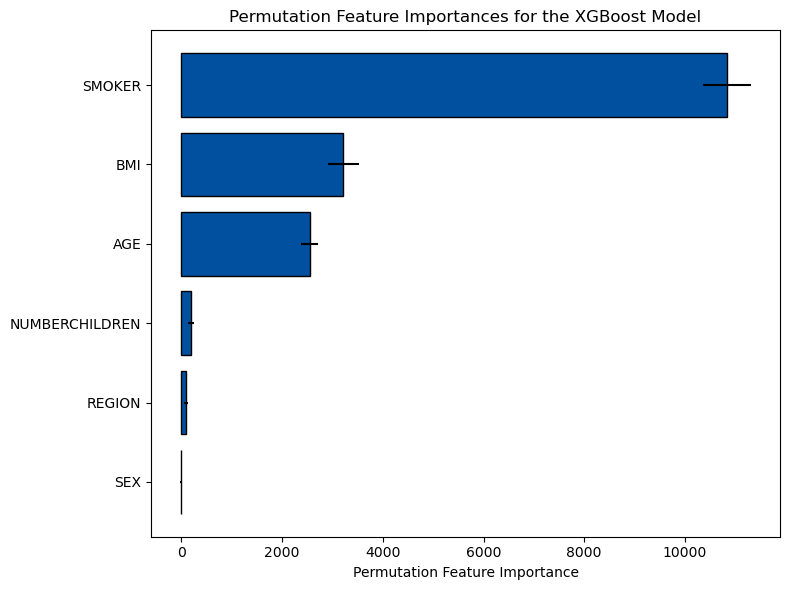

In [39]:
# Create the preprocessing steps for both numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create the XGBoost regressor model
model = XGBRegressor(
    n_estimators=100, learning_rate=0.05, random_state=RANDOM_SEED
)

# Create the pipeline
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('model', model)]
)

# Fit the pipeline
pipeline.fit(X_raw_train, y_train)

# Evaluate the model on the test set using RMSE and R² score
rmse_XGB_raw = mean_squared_error(
    y_test, pipeline.predict(X_raw_test), squared=False
)
r2_XGB_raw = r2_score(y_test, pipeline.predict(X_raw_test))

# Print the RMSE and R² score
print(f"RMSE for the XGBoost model on the test data: {rmse_XGB_raw:.2f}")
print(f"R² score for the XGBoost model on the test data: {r2_XGB_raw:.2f}")

# Perform permutation importance
results = permutation_importance(
    pipeline, X_raw_test, y_test, 
    scoring='neg_root_mean_squared_error', 
    n_repeats=1000,                         
    random_state=RANDOM_SEED                
)

# Sort feature importances in descending order and get their indices
sorted_idx = results.importances_mean.argsort()

# Get the standard deviations for the sorted features
sorted_std = results.importances_std[sorted_idx]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    range(len(sorted_idx)),
    results.importances_mean[sorted_idx],
    color=COLOR_DARK,
    edgecolor='black',
    xerr=sorted_std
)
plt.yticks(
    range(len(sorted_idx)),
    [X_raw_test.columns[i] for i in sorted_idx]
)
plt.xlabel("Permutation Feature Importance")
plt.title("Permutation Feature Importances for the XGBoost Model")
plt.tight_layout()
plt.show()

<h1 id="subsection_actuarialdiligencePDPALE"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    A.2 Deep Dive: PDP vs. ALE
    <a class="anchor-link"
       href="#c1"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

matplotlib.legend:WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


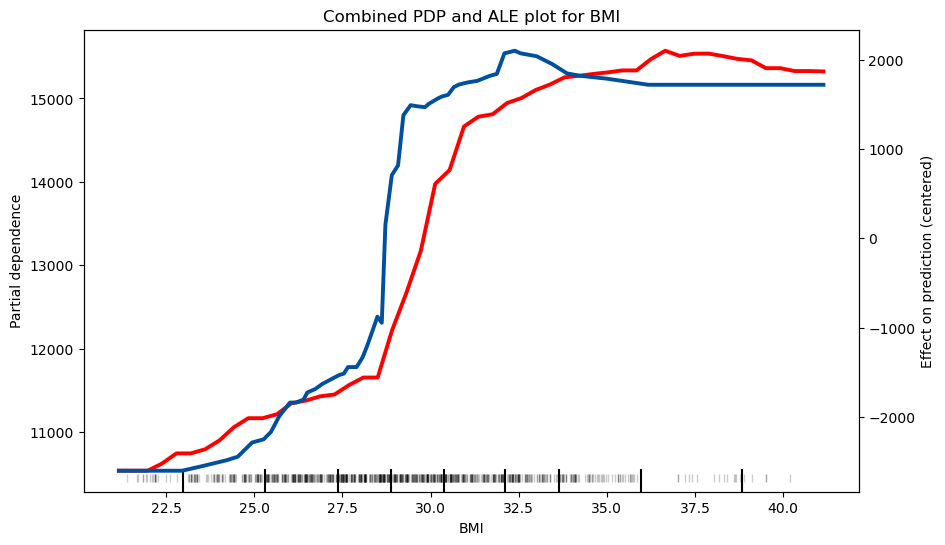

In [40]:
# Set the feature to be considered
feature_name = 'BMI'

# Create the figure for the combined plots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Generate PDP with PartialDependenceDisplay.from_estimator
pdp_display = PartialDependenceDisplay.from_estimator(
    model_CB_raw,
    X_raw_train,
    features=[X_raw_test.columns.get_loc(name) for name in [feature_name]],
    kind='average',
    grid_resolution=50,
    feature_names=numerical_features,
    pd_line_kw={'color': 'red', 'linewidth': 2.8, 'linestyle': '-'},
    ax=ax1
)

pdp_display.axes_[0][0].set_xlabel(feature_name)

ax2 = ax1.twinx()

ale_plot = ale(
    X=X_raw_train,  # DataFrame containing the training feature data
    model=model_CB_raw,  # Trained model
    feature=[feature_name],  # Feature to analyze
    feature_type='continuous',
    grid_size=50,  # Grid size can be set or left default
    include_CI=False,
    fig=fig,
    ax=ax2  # Use the i-th axis for the plot
)

# Adjust line style and color
ax2.lines[0].set_color(COLOR_DARK)
ax2.lines[0].set_linewidth(2.8)

# Set title for each subplot
ax2.set_title("")

# Add labels and legend to the original figure
ax1.set_title(f'Combined PDP and ALE plot for {feature_name}')
ax1.set_ylabel('Effect on model output')
ax1.legend()

plt.show()

<h1 id="subsection_actuarialdiligenceSHAP"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    A.3 Deep Dive: Diverse Feature Importance Methods
    <a class="anchor-link"
       href="#a3"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

In this notebook, we have explored two model-agnostic methods for calculating feature importances: Permutation Feature Importance, which we discussed in Subsection 4.4, and feature importance based on mean absolute SHAP values derived in Subsection 5.1. Comparing the outcomes of these methods is crucial, as it can lend credibility to the results by demonstrating their robustness. This section is dedicated to the comparison of the two mentioned model-agnostic feature importance methods, as well as a model-specific technique, namely CatBoost's internal feature importance. More details on how CatBoost calculates its internal feature importance can be found in TODO.

<h1 id="subsection_actuarialdiligenceSHAP"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    A.4 Deep Dive: Variants of SHAP
    <a class="anchor-link"
       href="#a4"
       target="_self"
       rel=" noreferrer nofollow">
    </a>
    <hr style="border: none; border-top: 3px solid black; margin-top: 10px;">
</h1>

In [41]:
# Create various SHAP explainers using the training set
expl_kernel = shap.KernelExplainer(
    model_CB_raw.predict, X_raw_train
)
expl_tree = shap.TreeExplainer(
    model_CB_raw
)
expl_sampling = shap.KernelExplainer(
    model_CB_raw.predict, X_raw_train, algorithm='sampling'
)
expl_permutation = shap.KernelExplainer(
    model_CB_raw.predict, X_raw_train, algorithm='permutation'
)

# Calculate SHAP values for the test set
shap_values_kernel = expl_kernel.shap_values(X_raw_test)
shap_values_tree = expl_tree.shap_values(X_raw_test)
shap_values_sampling = expl_sampling.shap_values(X_raw_test)
shap_values_permutation = expl_permutation.shap_values(X_raw_test)

shap:WARNING: Using 936 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shap:WARNING: Using 936 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shap:WARNING: Using 936 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  5%|▍         | 20/402 [00:08<02:47,  2.28it/s]


KeyboardInterrupt: 

In [ ]:
# Create an Explanation object for the first instance in the foreground set
explan_kernel = shap.Explanation(
    values=shap_values_kernel[observation_index],
    base_values=expl_kernel.expected_value,
    data=X_raw_test.iloc[observation_index]
)

# Plot the waterfall chart
shap.waterfall_plot(explan_kernel)

# Create an Explanation object for the first instance in the foreground set
explan_tree = shap.Explanation(
    values=shap_values_tree[observation_index],
    base_values=expl_tree.expected_value,
    data=X_raw_test.iloc[observation_index]
)

# Plot the waterfall chart
shap.waterfall_plot(explan_tree)

<h1 id="section_references" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">References</h1>

<a href="https://www.flaticon.com/free-icons/medical-invoice" title="medical invoice icons">Medical invoice icons created by Iconjam - Flaticon</a>

[1] https://www.kaggle.com/datasets/mirichoi0218/insurance

[2] Molnar, C. (2022). Interpretable Machine Learning:
A Guide for Making Black Box Models Explainable (2nd ed.).
christophm.github.io/interpretable-ml-book/